<a href="https://colab.research.google.com/github/Jules-gatete/FastAPI/blob/main/ML_Pipeline_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pharmaceutical Disposal Prediction - ML Pipeline



This notebook demonstrates the complete Machine Learning pipeline for predicting pharmaceutical disposal information from generic medicine names.



## Pipeline Overview:

1. **Data Loading** (Figure 3.1) – Load Rwanda FDA medicines dataset

2. **Data Preprocessing** (Figures 3.2–3.3) – Clean, normalize, and standardize data

3. **Exploratory Data Analysis** (Figures 4.1–4.8) – Analyze distributions, encoding workflow, and optimization steps

4. **Feature Engineering** – Create embeddings and engineered features

5. **Model Training** – Train classification models

6. **Model Evaluation** (Figures 5.1–5.3) – Evaluate model performance

7. **Model Testing** – Test on new data

8. **Model Saving** – Save trained models



---


In [ ]:
#mount the data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import required libraries

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import pickle

import os

import re

import warnings

from collections import Counter

from sklearn.ensemble import RandomForestClassifier

from sklearn.multioutput import MultiOutputClassifier

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split, learning_curve

from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

from sentence_transformers import SentenceTransformer

import matplotlib.patches as mpatches



# Try to import XGBoost

try:

    from xgboost import XGBClassifier

    USE_XGBOOST = True

    print("✓ XGBoost available")

except ImportError:

    USE_XGBOOST = False

    print("⚠ XGBoost not available, using RandomForest")



warnings.filterwarnings('ignore')



# Set style for better visualizations

try:

    plt.style.use('seaborn-v0_8-darkgrid')

except:

    try:

        plt.style.use('seaborn-darkgrid')

    except:

        plt.style.use('ggplot')
sns.set_palette("husl")



# Configuration

DATA_FILE = '/content/drive/MyDrive/UmutiSafe/Updated_pipeline/rwanda_fda_medicines_with_disposal.csv'

BASE_SAVE_DIR = '/content/drive/MyDrive/UmutiSafe/Updated_pipeline'
MODELS_DIR = os.path.join(BASE_SAVE_DIR, 'models')
IMAGES_DIR = os.path.join(BASE_SAVE_DIR, 'Images')

EMBEDDING_MODEL_NAME = 'all-MiniLM-L6-v2'

MIN_CLASS_FREQUENCY = 3

TEST_SIZE = 0.2



# Ensure directories exist

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)



print("✓ All libraries imported successfully!")

✓ XGBoost available
✓ All libraries imported successfully!


## 1. Data Loading

Load the Rwanda FDA medicines dataset with disposal information.


In [ ]:
# Load the dataset
print("Loading dataset...")
df_raw = pd.read_csv(DATA_FILE)

print(f"✓ Dataset loaded successfully!")
print(f"  - Total records: {len(df_raw)}")
print(f"  - Total columns: {len(df_raw.columns)}")
print(f"\nColumn names:")
print(df_raw.columns.tolist())


Loading dataset...
✓ Dataset loaded successfully!
  - Total records: 2338
  - Total columns: 20

Column names:
['No.', 'Registration No.', 'Product Brand Name', 'Generic Name', 'Dosage Strength', 'Dosage Form', 'Pack Size', 'Packaging Type', 'Shelf Life', "Manufacturer's Name", "Manufacturer's Address", 'Manufacturer Country', 'Marketing Authorization Holder(MAH)', 'Local Technical Representative(LTR)', 'Registration Date', 'Expiry Date', 'Disposal Category', 'Handling Method', 'Method of Disposal', 'Disposal Remarks']


### Figure 3.1: Sample of the Raw FDA Rwanda Dataset

Displaying the first 15 rows to show the dataset structure.


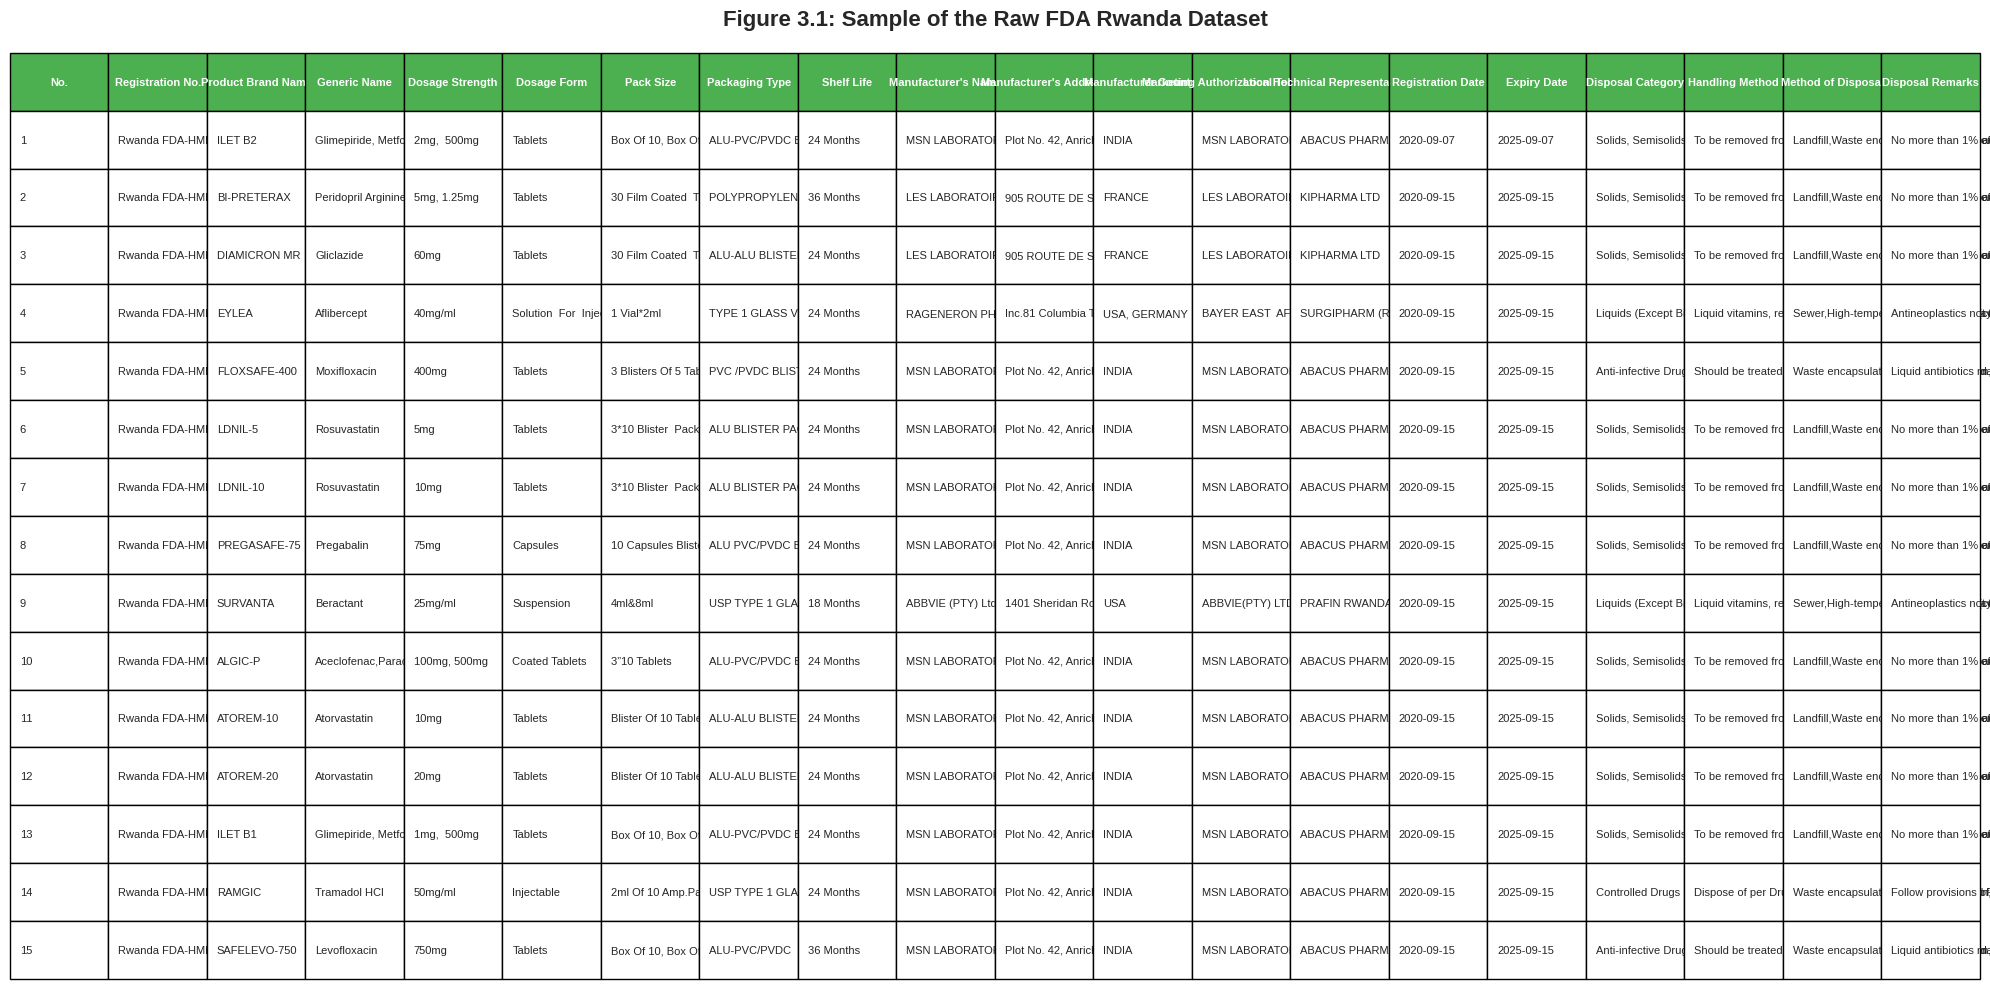


Dataset Info:
  - Shape: (2338, 20)
  - Memory usage: 4.20 MB

First few rows:


,No.,Registration No.,Product Brand Name,Generic Name,Dosage Strength,Dosage Form,Pack Size,Packaging Type,Shelf Life,Manufacturer's Name,Manufacturer's Address,Manufacturer Country,Marketing Authorization Holder(MAH),Local Technical Representative(LTR),Registration Date,Expiry Date,Disposal Category,Handling Method,Method of Disposal,Disposal Remarks
0,1,Rwanda FDA-HMP-MA-0033,ILET B2,"Glimepiride, Metformin HCl","2mg, 500mg",Tablets,"Box Of 10, Box Of 30",ALU-PVC/PVDC BLISTER PACK,24 Months,MSN LABORATORIES PRIVATE LIMITED (Formulations...,"Plot No. 42, Anrich Industrial Estate, Bollara...",INDIA,MSN LABORATORIES PRIVATE LIMITED,ABACUS PHARMA (A) LTD,2020-09-07,2025-09-07,"Solids, Semisolids, Powders (Except Biological...",To be removed from outer packaging but remain ...,"Landfill,Waste encapsulation,Waste inertizatio...",No more than 1% of daily municipal waste shoul...
1,2,Rwanda FDA-HMP-MA-0021,BI-PRETERAX,"Peridopril Arginine, Indapamide","5mg, 1.25mg",Tablets,30 Film Coated Tablets,POLYPROPYLENE CONTAINER,36 Months,LES LABORATOIRES SERVIER,"905 ROUTE DE SARAN, 45520 GIDY, FRANCE",FRANCE,LES LABORATOIRES SERVIER,KIPHARMA LTD,2020-09-15,2025-09-15,"Solids, Semisolids, Powders (Except Biological...",To be removed from outer packaging but remain ...,"Landfill,Waste encapsulation,Waste inertizatio...",No more than 1% of daily municipal waste shoul...
2,3,Rwanda FDA-HMP-MA-0022,DIAMICRON MR,Gliclazide,60mg,Tablets,30 Film Coated Tablets,ALU-ALU BLISTER PACK,24 Months,LES LABORATOIRES SERVIER,"905 ROUTE DE SARAN, 45520 GIDY, FRANCE",FRANCE,LES LABORATOIRES SERVIER,KIPHARMA LTD,2020-09-15,2025-09-15,"Solids, Semisolids, Powders (Except Biological...",To be removed from outer packaging but remain ...,"Landfill,Waste encapsulation,Waste inertizatio...",No more than 1% of daily municipal waste shoul...
3,4,Rwanda FDA-HMP-MA-0023,EYLEA,Aflibercept,40mg/ml,Solution For Injection,1 Vial*2ml,TYPE 1 GLASS VIAL,24 Months,"RAGENERON PHARMACEUTICALS, VETTER PHARMA-FERT...","Inc.81 Columbia Turnpike, Rensselaer, New York...","USA, GERMANY",BAYER EAST AFRICA LIMITED,SURGIPHARM (RWANDA) LTD,2020-09-15,2025-09-15,Liquids (Except Biological Waste),"Liquid vitamins, readily biodegradable organic...","Sewer,High-temperature incineration (cement ki...",Antineoplastics not to be sent to sewer.
4,5,Rwanda FDA-HMP-MA-0024,FLOXSAFE-400,Moxifloxacin,400mg,Tablets,3 Blisters Of 5 Tablets,PVC /PVDC BLISTER PACK,24 Months,MSN LABORATORIES PRIVATE LIMITED (Formulations...,"Plot No. 42, Anrich Industrial Estate, Bollara...",INDIA,MSN LABORATORIES PRIVATE LIMITED,ABACUS PHARMA (A) LTD,2020-09-15,2025-09-15,Anti-infective Drugs,Should be treated before disposal. Dilute in w...,"Waste encapsulation,Waste inertization,Medium ...","Liquid antibiotics may be diluted with water, ..."


In [ ]:
# Display first 15 rows with all columns
fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('tight')
ax.axis('off')

# Create table
table_data = df_raw.head(15)
table = ax.table(cellText=table_data.values,
                colLabels=table_data.columns,
                cellLoc='left',
                loc='center',
                bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 2)

# Style the table
for i in range(len(table_data.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Figure 3.1: Sample of the Raw FDA Rwanda Dataset',
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
fig.savefig(os.path.join(IMAGES_DIR, 'Figure_3_1_Sample_of_the_Raw_FDA_Rwanda_Dataset.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nDataset Info:")
print(f"  - Shape: {df_raw.shape}")
print(f"  - Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nFirst few rows:")
df_raw.head()


## 2. Data Preprocessing

Clean, normalize, and standardize the raw dataset prior to feature analysis.


### Figure 3.2: OCR Text Extraction Pipeline

Visualizing the OCR pipeline workflow.


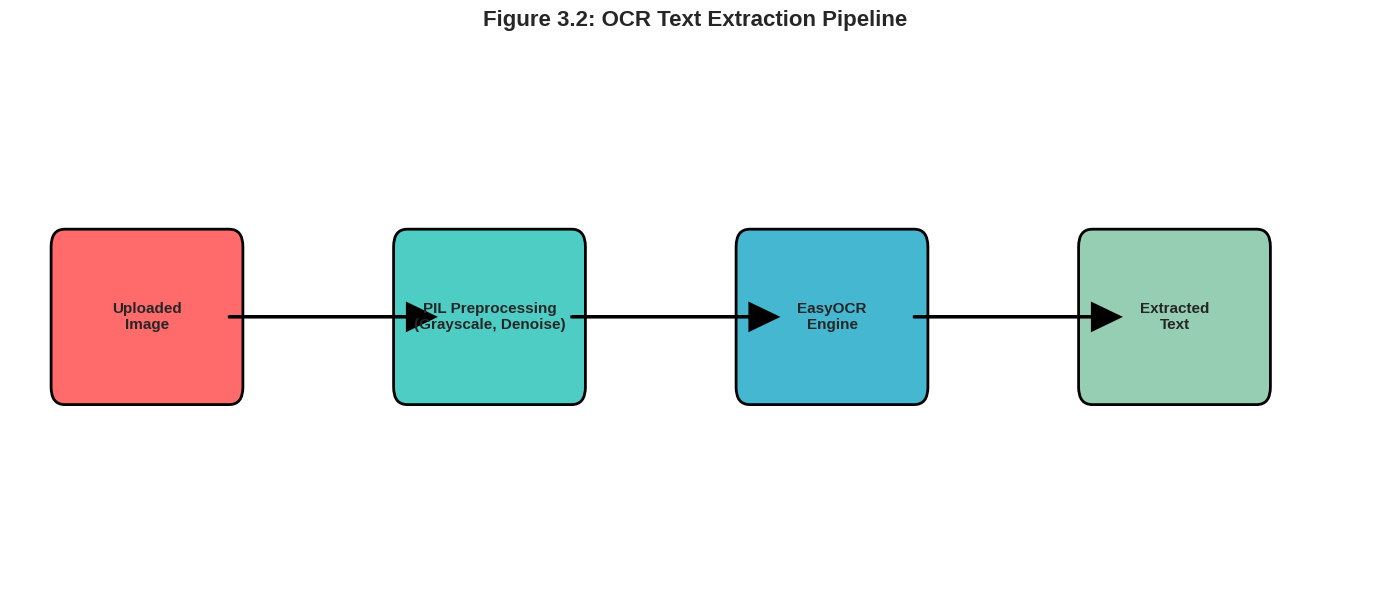

In [ ]:
# Create OCR Pipeline Flowchart
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 3)
ax.axis('off')

# Define boxes
boxes = [
    {'text': 'Uploaded\nImage', 'pos': (1, 1.5), 'color': '#FF6B6B'},
    {'text': 'PIL Preprocessing\n(Grayscale, Denoise)', 'pos': (3.5, 1.5), 'color': '#4ECDC4'},
    {'text': 'EasyOCR\nEngine', 'pos': (6, 1.5), 'color': '#45B7D1'},
    {'text': 'Extracted\nText', 'pos': (8.5, 1.5), 'color': '#96CEB4'}
]

# Draw boxes
for i, box in enumerate(boxes):
    rect = mpatches.FancyBboxPatch(
        (box['pos'][0] - 0.6, box['pos'][1] - 0.4),
        1.2, 0.8,
        boxstyle="round,pad=0.1",
        edgecolor='black',
        facecolor=box['color'],
        linewidth=2
)
    ax.add_patch(rect)
    ax.text(box['pos'][0], box['pos'][1], box['text'],
            ha='center', va='center', fontsize=11, fontweight='bold')

# Draw arrows
for i in range(len(boxes) - 1):
    ax.arrow(boxes[i]['pos'][0] + 0.6, boxes[i]['pos'][1],
             boxes[i+1]['pos'][0] - boxes[i]['pos'][0] - 1.2, 0,
             head_width=0.15, head_length=0.2, fc='black', ec='black', lw=2)

plt.title('Figure 3.2: OCR Text Extraction Pipeline',
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
fig.savefig(os.path.join(IMAGES_DIR, 'Figure_3_2_OCR_Text_Extraction_Pipeline.png'), dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Preprocessing functions
def normalize_text(text):
    """Normalize text: lowercase, strip, remove extra spaces."""
    if pd.isna(text):
        return ''
    text = str(text).lower().strip()
    text = re.sub(r'\s+', ' ', text)
    return text

def standardize_dosage_form(df):
    """Standardize Dosage Form variations."""
    dosage_mapping = {
        'tablet': 'tablets', 'tablets': 'tablets',
        'film coated tablet': 'film coated tablets',
        'film-coated tablet': 'film coated tablets',
        'capsule': 'capsules', 'capsules': 'capsules',
        'suspension': 'suspension', 'syrup': 'syrup',
        'injection': 'injection', 'cream': 'cream',
        'ointment': 'ointment', 'powder': 'powder'
    }

    df['Dosage Form Normalized'] = df['Dosage Form'].apply(normalize_text)
    df['Dosage Form Standardized'] = df['Dosage Form Normalized'].map(
        dosage_mapping
    ).fillna(df['Dosage Form Normalized'])

    return df

# Preprocess data
print("Preprocessing data...")
df = df_raw.copy()

# Handle missing values
initial_count = len(df)
df = df.dropna(subset=['Generic Name'])
print(f"  - Dropped {initial_count - len(df)} records with missing Generic Names")

# Normalize Generic Name
df['Generic Name'] = df['Generic Name'].apply(normalize_text)
df = df[df['Generic Name'] != '']

# Standardize Dosage Form
df = standardize_dosage_form(df)

# Normalize other columns
df['Manufacturer Normalized'] = df["Manufacturer's Name"].apply(normalize_text)
df['Disposal Category Normalized'] = df['Disposal Category'].apply(normalize_text)

print(f"✓ Preprocessing complete!")
print(f"  - Final dataset size: {len(df)} records")
print(f"  - Unique Generic Names: {df['Generic Name'].nunique()}")
print(f"  - Unique Dosage Forms: {df['Dosage Form Standardized'].nunique()}")


Preprocessing data...
  - Dropped 4 records with missing Generic Names
✓ Preprocessing complete!
  - Final dataset size: 2334 records
  - Unique Generic Names: 2000
  - Unique Dosage Forms: 310


### Figure 3.3: Data Preprocessing and Integration Workflow

Visualizing the preprocessing pipeline.


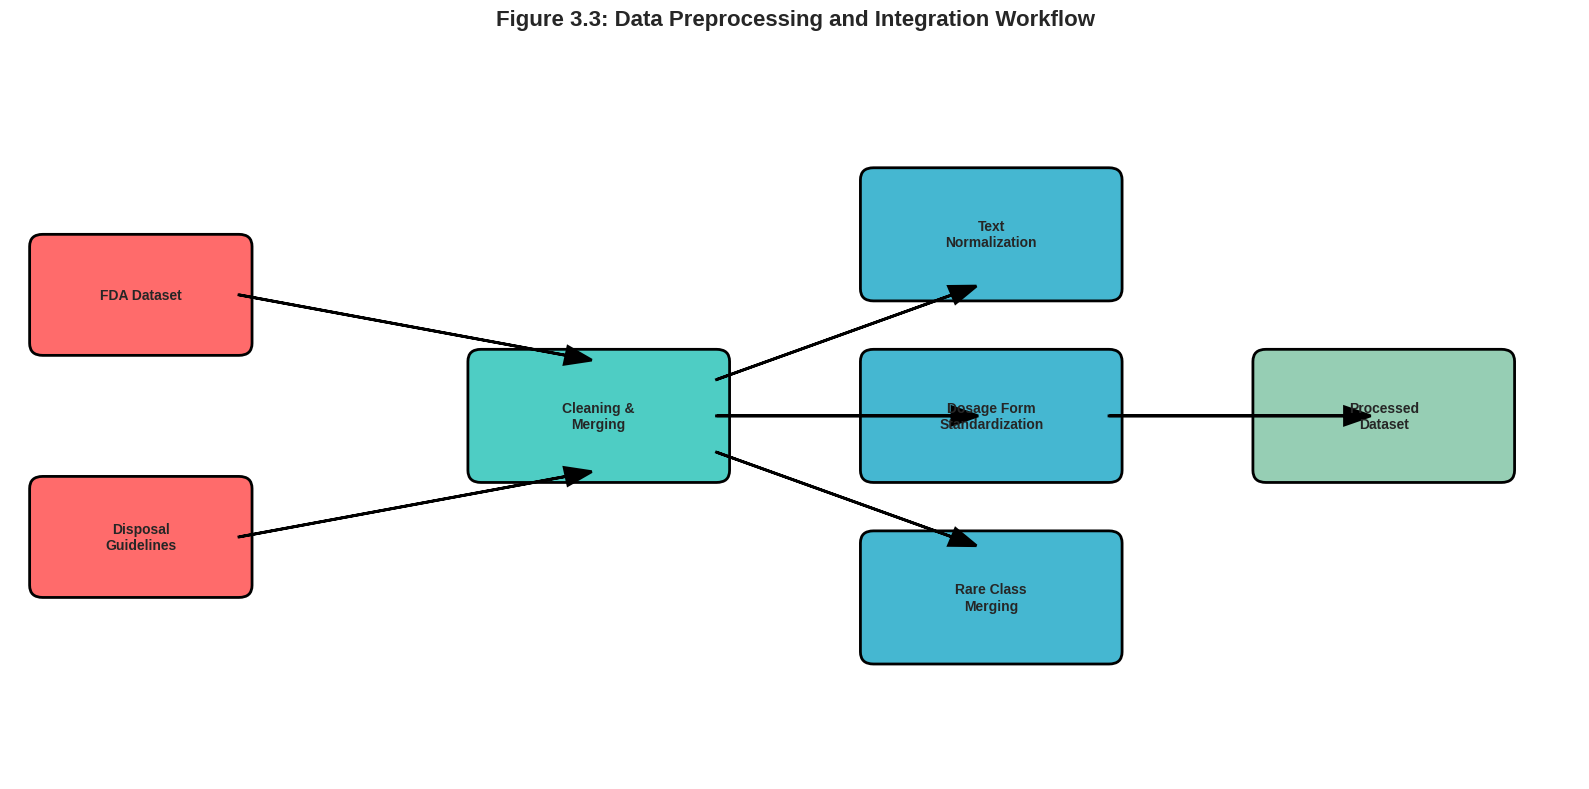

In [ ]:
# Create Preprocessing Workflow Diagram
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_xlim(0, 12)
ax.set_ylim(0, 6)
ax.axis('off')

# Define workflow boxes
workflow = [
    {'text': 'FDA Dataset', 'pos': (1, 4), 'color': '#FF6B6B', 'level': 0},
    {'text': 'Disposal\nGuidelines', 'pos': (1, 2), 'color': '#FF6B6B', 'level': 0},
    {'text': 'Cleaning &\nMerging', 'pos': (4.5, 3), 'color': '#4ECDC4', 'level': 1},
    {'text': 'Text\nNormalization', 'pos': (7.5, 4.5), 'color': '#45B7D1', 'level': 2},
    {'text': 'Dosage Form\nStandardization', 'pos': (7.5, 3), 'color': '#45B7D1', 'level': 2},
    {'text': 'Rare Class\nMerging', 'pos': (7.5, 1.5), 'color': '#45B7D1', 'level': 2},
    {'text': 'Processed\nDataset', 'pos': (10.5, 3), 'color': '#96CEB4', 'level': 3}
]

# Draw boxes
for box in workflow:
    width = 1.5 if box['level'] == 0 else 1.8
    height = 0.8 if box['level'] == 0 else 0.9

    rect = mpatches.FancyBboxPatch(
        (box['pos'][0] - width/2, box['pos'][1] - height/2),
        width, height,
        boxstyle="round,pad=0.1",
        edgecolor='black',
        facecolor=box['color'],
        linewidth=2
)
    ax.add_patch(rect)
    ax.text(box['pos'][0], box['pos'][1], box['text'],
            ha='center', va='center', fontsize=10, fontweight='bold')

# Draw arrows
# From inputs to cleaning
ax.arrow(1.75, 4, 2.5, -0.5, head_width=0.15, head_length=0.2, fc='black', ec='black', lw=2)
ax.arrow(1.75, 2, 2.5, 0.5, head_width=0.15, head_length=0.2, fc='black', ec='black', lw=2)

# From cleaning to processing steps
ax.arrow(5.4, 3.3, 1.8, 0.7, head_width=0.15, head_length=0.2, fc='black', ec='black', lw=2)
ax.arrow(5.4, 3, 1.8, 0, head_width=0.15, head_length=0.2, fc='black', ec='black', lw=2)
ax.arrow(5.4, 2.7, 1.8, -0.7, head_width=0.15, head_length=0.2, fc='black', ec='black', lw=2)

# From processing to output
ax.arrow(8.4, 3, 1.8, 0, head_width=0.15, head_length=0.2, fc='black', ec='black', lw=2)

plt.title('Figure 3.3: Data Preprocessing and Integration Workflow',
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
fig.savefig(os.path.join(IMAGES_DIR, 'Figure_3_3_Data_Preprocessing_and_Integration_Workflow.png'), dpi=300, bbox_inches='tight')
plt.show()


## 3. Exploratory Data Analysis

Analyze the dataset to understand distributions and patterns.


### Figure 4.1: Dataset Overview Visualization

This composite view highlights key dataset properties at a glance: top manufacturing countries, dosage form mix, shelf-life distribution, and registration activity over time.


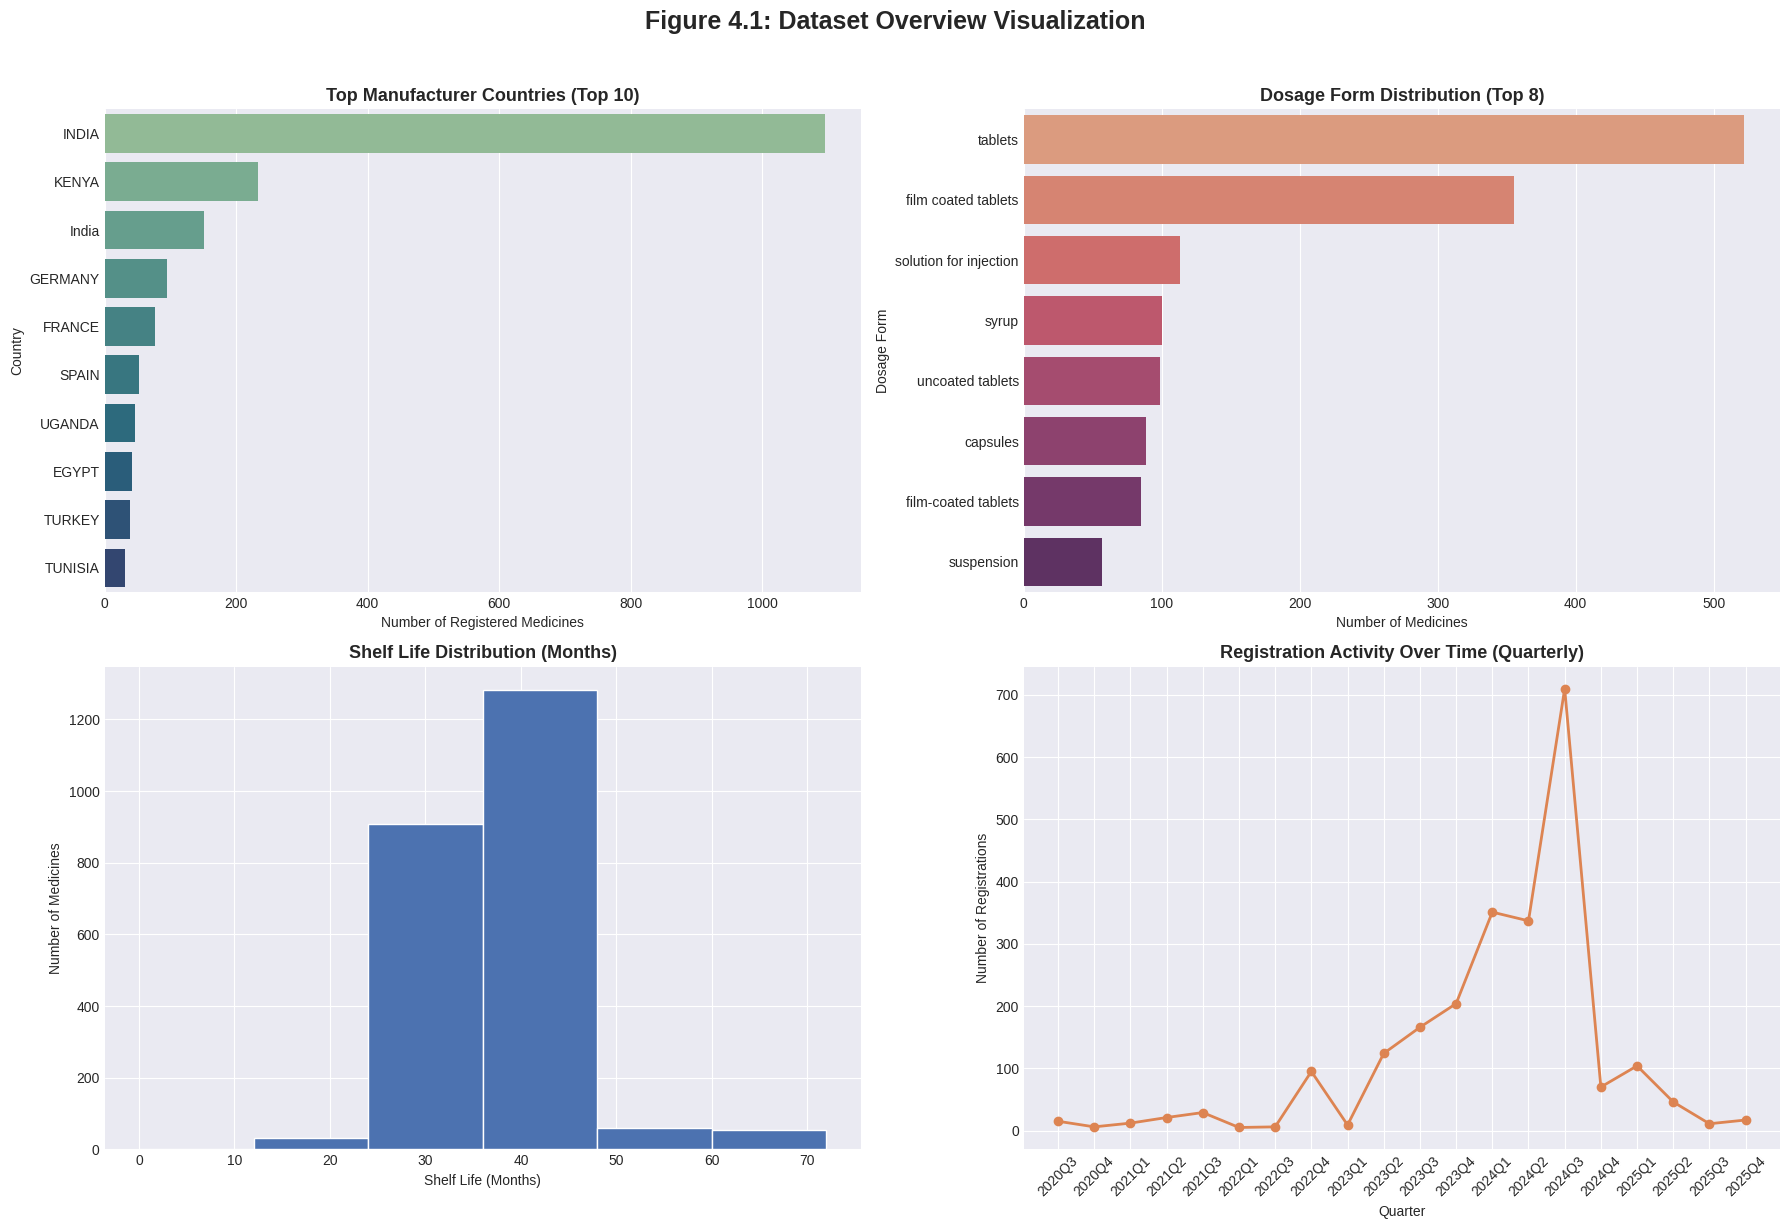

In [ ]:
# Figure 4.1: Dataset Overview Visualization

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

plt.subplots_adjust(hspace=0.45, wspace=0.3)



# Prepare manufacturing country counts (split multi-country entries)

manufacturer_countries = (

    df_raw['Manufacturer Country']

    .dropna()

    .astype(str)

    .str.split(',')

    .explode()

    .str.strip()

)

manufacturer_countries = manufacturer_countries[manufacturer_countries != '']

top_countries = manufacturer_countries.value_counts().head(10)



if not top_countries.empty:

    sns.barplot(

        x=top_countries.values,

        y=top_countries.index,

        ax=axes[0, 0],

        orient='h',

        palette='crest'

    )

    axes[0, 0].set_xlabel('Number of Registered Medicines')

    axes[0, 0].set_ylabel('Country')

else:

    axes[0, 0].text(0.5, 0.5, 'No manufacturer data available', ha='center', va='center')

axes[0, 0].set_title('Top Manufacturer Countries (Top 10)', fontsize=13, fontweight='bold')



# Dosage form mix

dosage_counts = df['Dosage Form Standardized'].value_counts().head(8)

if not dosage_counts.empty:

    sns.barplot(

        x=dosage_counts.values,

        y=dosage_counts.index,

        ax=axes[0, 1],

        orient='h',

        palette='flare'

    )

    axes[0, 1].set_xlabel('Number of Medicines')

    axes[0, 1].set_ylabel('Dosage Form')

else:

    axes[0, 1].text(0.5, 0.5, 'No dosage form data available', ha='center', va='center')

axes[0, 1].set_title('Dosage Form Distribution (Top 8)', fontsize=13, fontweight='bold')



# Shelf life distribution in months

shelf_life_months = (

    df_raw['Shelf Life']

    .astype(str)

    .str.extract(r'(\d+)')

    .dropna()[0]

    .astype(int)

)

if not shelf_life_months.empty:

    bin_edge = max(12, ((shelf_life_months.max() // 12) + 1) * 12)

    axes[1, 0].hist(

        shelf_life_months,

        bins=range(0, bin_edge + 12, 12),

        color='#4c72b0',

        edgecolor='white'

    )

    axes[1, 0].set_xlabel('Shelf Life (Months)')

    axes[1, 0].set_ylabel('Number of Medicines')

else:

    axes[1, 0].text(0.5, 0.5, 'No shelf life data available', ha='center', va='center')

axes[1, 0].set_title('Shelf Life Distribution (Months)', fontsize=13, fontweight='bold')



# Registration activity over time (quarterly)

registration_dates = pd.to_datetime(df_raw['Registration Date'], errors='coerce')

registration_quarterly = (

    registration_dates

    .dropna()

    .dt.to_period('Q')

    .value_counts()

    .sort_index()

)

if not registration_quarterly.empty:

    axes[1, 1].plot(

        registration_quarterly.index.astype(str),

        registration_quarterly.values,

        color='#dd8452',

        marker='o',

        linewidth=2

    )

    axes[1, 1].set_xlabel('Quarter')

    axes[1, 1].set_ylabel('Number of Registrations')

    axes[1, 1].tick_params(axis='x', rotation=45)

else:

    axes[1, 1].text(0.5, 0.5, 'No registration date data available', ha='center', va='center')

axes[1, 1].set_title('Registration Activity Over Time (Quarterly)', fontsize=13, fontweight='bold')



fig.suptitle('Figure 4.1: Dataset Overview Visualization', fontsize=18, fontweight='bold', y=1.02)

plt.tight_layout()

fig.savefig(

    os.path.join(IMAGES_DIR, 'Figure_4_1_Dataset_Overview_Visualization.png'),

    dpi=300,

    bbox_inches='tight'

)

plt.show()


### Figure 4.2: Distribution of Medicine Dosage Forms

This chart highlights the most common dosage forms within the dataset to understand how medicines are distributed by formulation type.


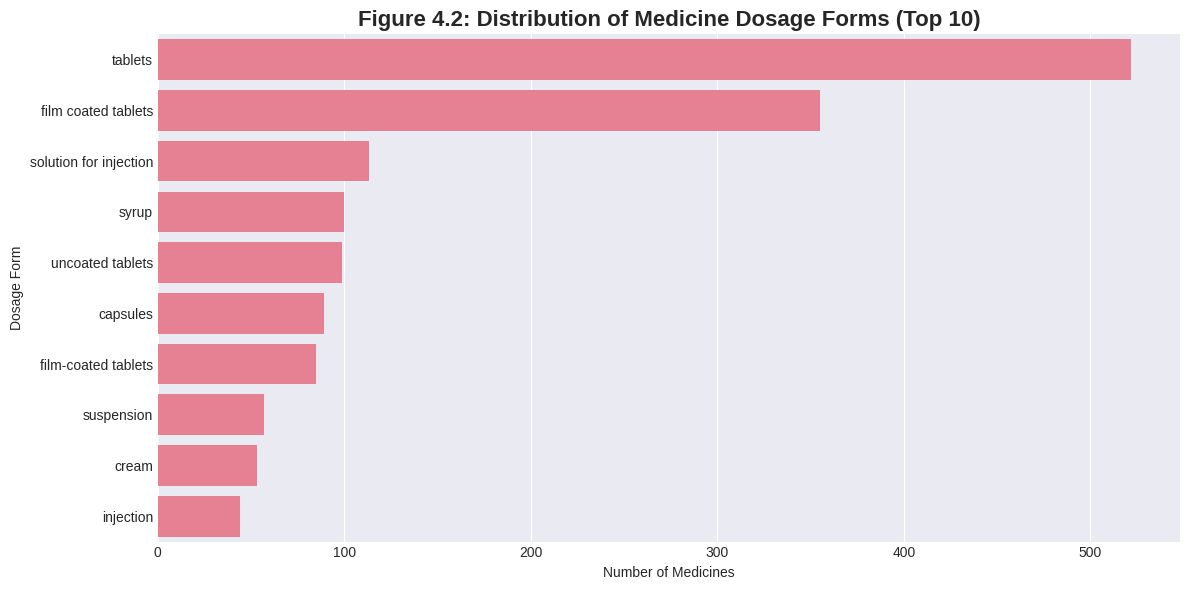

In [ ]:
# Figure 4.2: Distribution of Medicine Dosage Forms

fig, ax = plt.subplots(figsize=(12, 6))

top_dosage_forms = df['Dosage Form Standardized'].value_counts().head(10)

sns.barplot(x=top_dosage_forms.values, y=top_dosage_forms.index, ax=ax)

ax.set_title('Figure 4.2: Distribution of Medicine Dosage Forms (Top 10)', fontsize=16, fontweight='bold')

ax.set_xlabel('Number of Medicines')

ax.set_ylabel('Dosage Form')

plt.tight_layout()

fig.savefig(os.path.join(IMAGES_DIR, 'Figure_4_2_Distribution_of_Medicine_Dosage_Forms_Top_10.png'), dpi=300, bbox_inches='tight')

plt.show()


### Figure 4.3: Illustration of Categorical Data Encoding

Visual guide showing how categorical features are encoded into numerical representations to prepare the dataset for modeling.


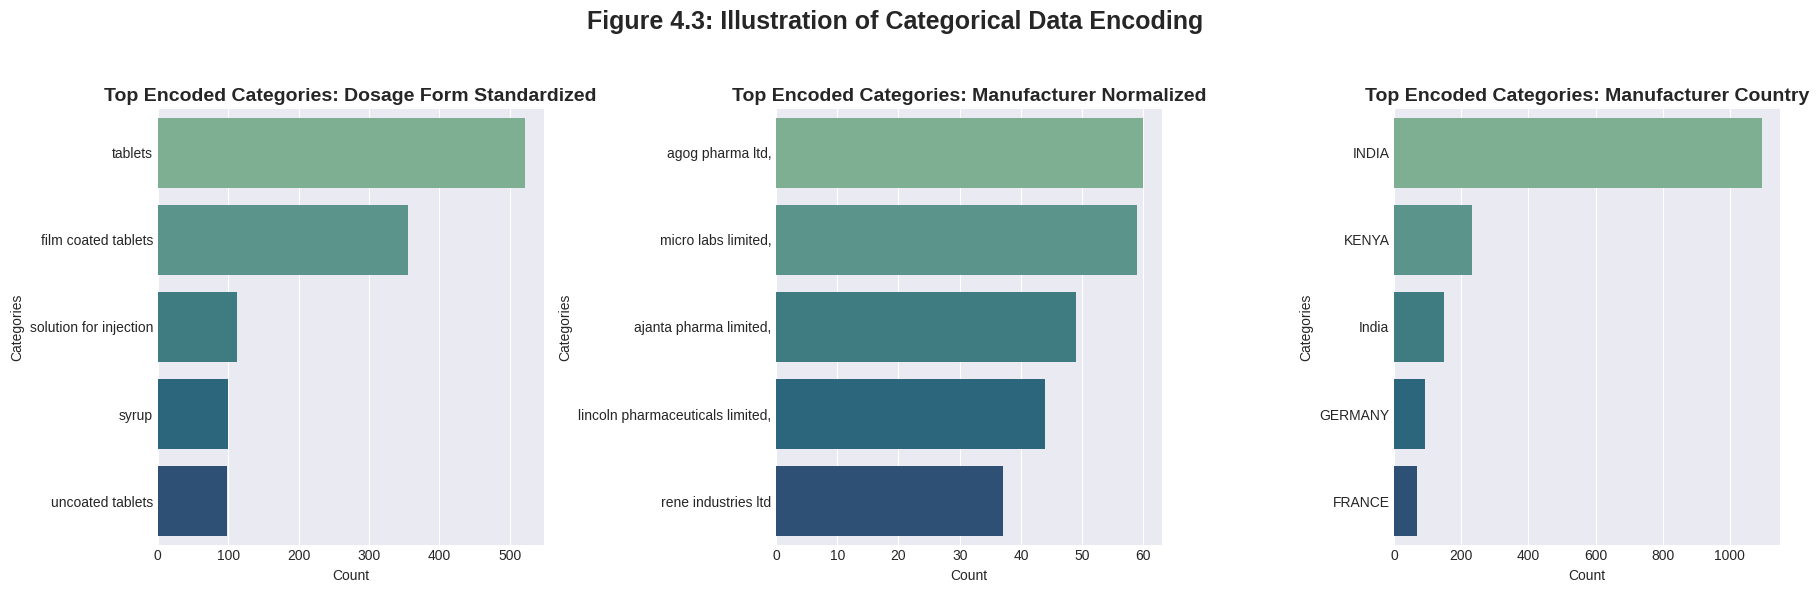

In [ ]:
# Figure 4.3: Illustration of Categorical Data Encoding

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

categorical_columns = ['Dosage Form Standardized', 'Manufacturer Normalized', 'Manufacturer Country']

for i, col in enumerate(categorical_columns):
    top_categories = df[col].astype(str).value_counts().head(5)
    sns.barplot(x=top_categories.values, y=top_categories.index, ax=axes[i], palette='crest')
    axes[i].set_title(f"Top Encoded Categories: {col}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('Categories')

plt.suptitle('Figure 4.3: Illustration of Categorical Data Encoding', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.94])
fig.savefig(os.path.join(IMAGES_DIR, 'Figure_4_3_Illustration_of_Categorical_Data_Encoding_Process.png'), dpi=300, bbox_inches='tight')
plt.show()

### Figure 4.4: Cleaned Dataset Sample After Preprocessing

Snapshot of the dataset once cleaning and encoding steps are completed, confirming the features used for modeling.


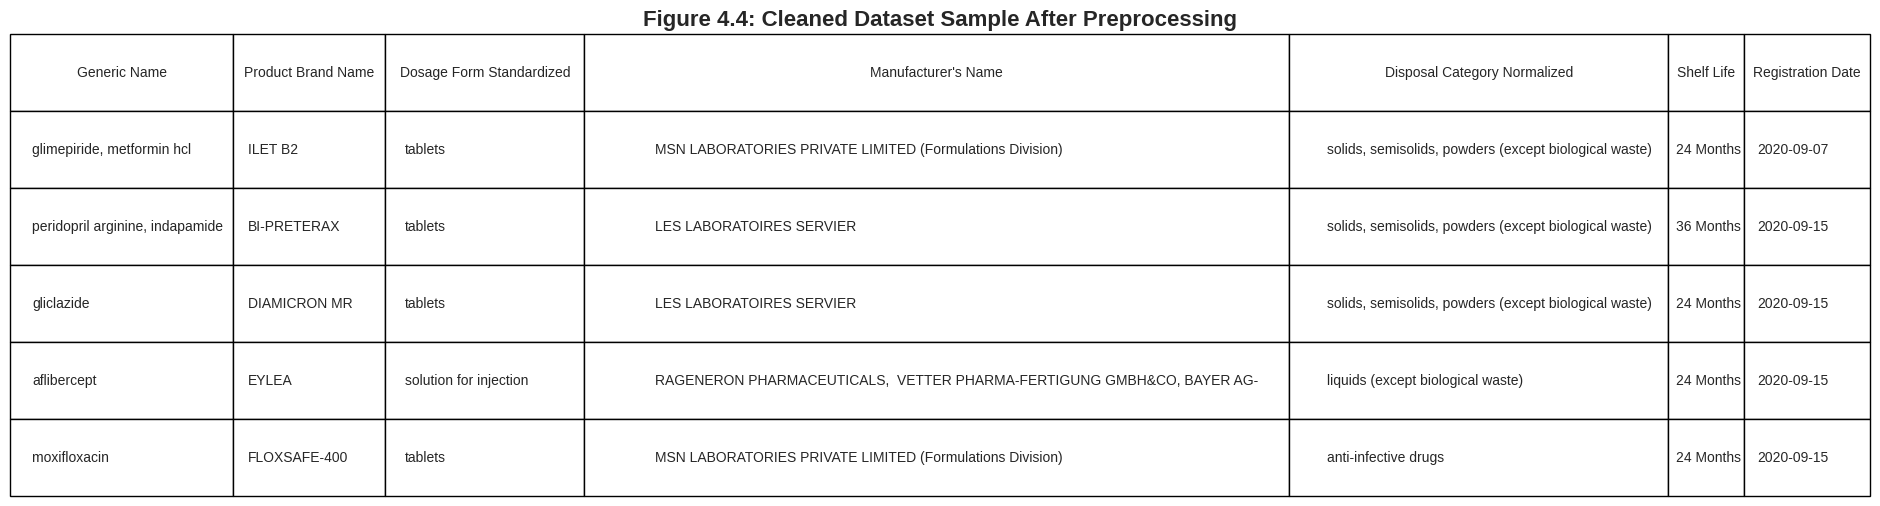

,Generic Name,Product Brand Name,Dosage Form Standardized,Manufacturer's Name,Disposal Category Normalized,Shelf Life,Registration Date
0,"glimepiride, metformin hcl",ILET B2,tablets,MSN LABORATORIES PRIVATE LIMITED (Formulations...,"solids, semisolids, powders (except biological...",24 Months,2020-09-07
1,"peridopril arginine, indapamide",BI-PRETERAX,tablets,LES LABORATOIRES SERVIER,"solids, semisolids, powders (except biological...",36 Months,2020-09-15
2,gliclazide,DIAMICRON MR,tablets,LES LABORATOIRES SERVIER,"solids, semisolids, powders (except biological...",24 Months,2020-09-15
3,aflibercept,EYLEA,solution for injection,"RAGENERON PHARMACEUTICALS, VETTER PHARMA-FERT...",liquids (except biological waste),24 Months,2020-09-15
4,moxifloxacin,FLOXSAFE-400,tablets,MSN LABORATORIES PRIVATE LIMITED (Formulations...,anti-infective drugs,24 Months,2020-09-15


In [ ]:
# Figure 4.4: Cleaned Dataset Sample After Preprocessing

display_columns = [
    'Generic Name',
    'Product Brand Name',
    'Dosage Form Standardized',
    "Manufacturer's Name",
    'Disposal Category Normalized',
    'Shelf Life',
    'Registration Date'
]
sample_df = df[display_columns].head(5)

fig, ax = plt.subplots(figsize=(24, 6)) # Increased figure size
ax.axis('off')

table = ax.table(
    cellText=sample_df.values,
    colLabels=sample_df.columns,
    cellLoc='left',
    colLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1] # Keeping bbox as [0,0,1,1] but with larger figure size
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.6)
table.auto_set_column_width(list(range(len(display_columns))))

plt.title('Figure 4.4: Cleaned Dataset Sample After Preprocessing', fontsize=16, fontweight='bold')
fig.savefig(os.path.join(IMAGES_DIR, 'Figure_4_4_Cleaned_Dataset_Sample_After_Preprocessing.png'), dpi=300, bbox_inches='tight')
plt.show()

display(sample_df)

### Figure 4.5: Visualization of Dataset Splitting

Depiction of how the dataset is divided into training and testing subsets to evaluate model performance.


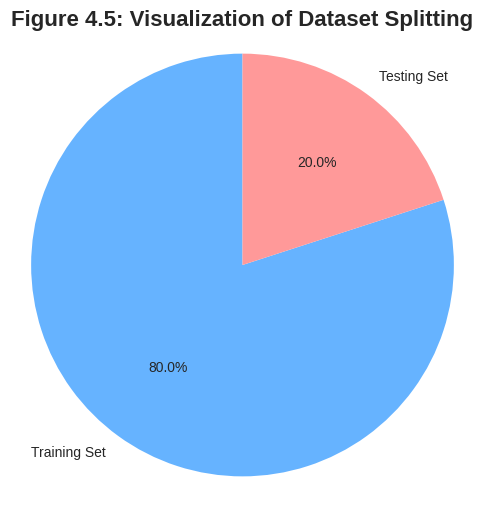

In [ ]:
# Figure 4.5: Visualization of Dataset Splitting

labels = ['Training Set', 'Testing Set']

train_count = int(len(df) * (1 - TEST_SIZE))

test_count = len(df) - train_count

sizes = [train_count, test_count]

colors = ['#66b3ff', '#ff9999']



fig, ax = plt.subplots(figsize=(6, 6))

ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)

ax.axis('equal')

ax.set_title('Figure 4.5: Visualization of Dataset Splitting', fontsize=16, fontweight='bold')

fig.savefig(os.path.join(IMAGES_DIR, 'Figure_4_5_Visualization_of_Dataset_Splitting.png'), dpi=300, bbox_inches='tight')

plt.show()


### Figure 4.6: Model Optimization Workflow Overview

Flow diagram summarizing the key steps in hyperparameter optimization and model selection for the final pipeline.


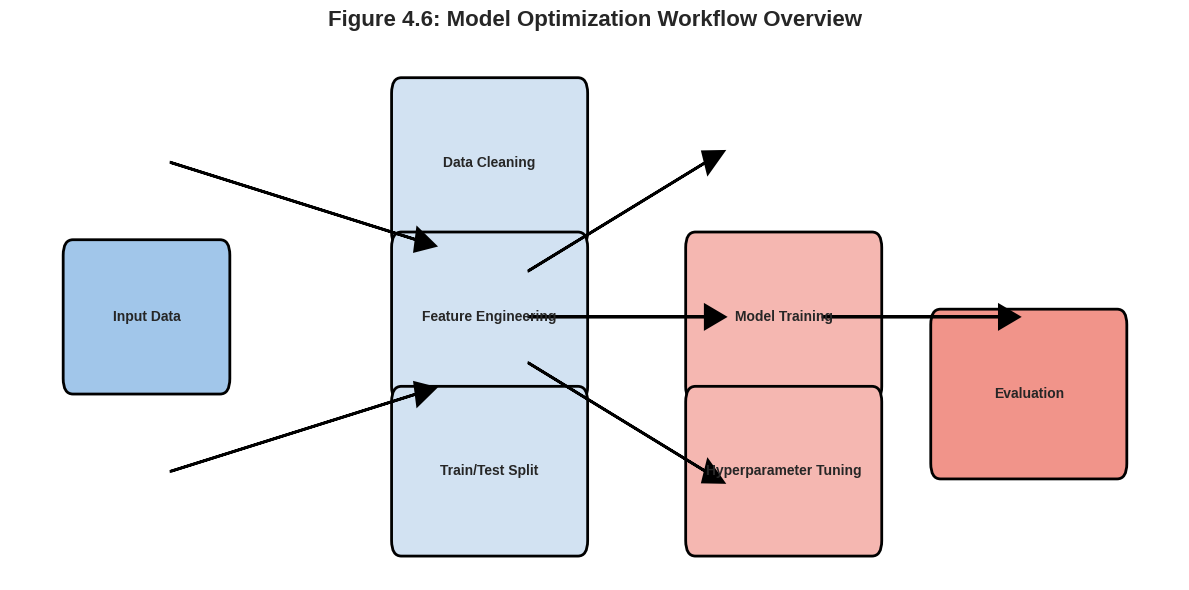

In [ ]:
# Figure 4.6: Model Optimization Workflow Overview

fig, ax = plt.subplots(figsize=(12, 6))

ax.axis('off')



workflow = [

    {'text': 'Input Data', 'pos': (1.5, 3), 'color': '#A1C6EA', 'level': 0},

    {'text': 'Data Cleaning', 'pos': (5, 4), 'color': '#D2E2F2', 'level': 1},

    {'text': 'Feature Engineering', 'pos': (5, 3), 'color': '#D2E2F2', 'level': 1},

    {'text': 'Train/Test Split', 'pos': (5, 2), 'color': '#D2E2F2', 'level': 1},

    {'text': 'Model Training', 'pos': (8, 3), 'color': '#F5B7B1', 'level': 2},

    {'text': 'Hyperparameter Tuning', 'pos': (8, 2), 'color': '#F5B7B1', 'level': 2},

    {'text': 'Evaluation', 'pos': (10.5, 2.5), 'color': '#F1948A', 'level': 3}

]



# Draw boxes

for box in workflow:

    width = 1.5 if box['level'] == 0 else 1.8

    height = 0.8 if box['level'] == 0 else 0.9



    rect = mpatches.FancyBboxPatch(

        (box['pos'][0] - width/2, box['pos'][1] - height/2),

        width, height,

        boxstyle="round,pad=0.1",

        edgecolor='black',

        facecolor=box['color'],

        linewidth=2

    )

    ax.add_patch(rect)

    ax.text(box['pos'][0], box['pos'][1], box['text'],

            ha='center', va='center', fontsize=10, fontweight='bold')



# Draw arrows

# From inputs to cleaning

ax.arrow(1.75, 4, 2.5, -0.5, head_width=0.15, head_length=0.2, fc='black', ec='black', lw=2)

ax.arrow(1.75, 2, 2.5, 0.5, head_width=0.15, head_length=0.2, fc='black', ec='black', lw=2)



# From cleaning to processing steps

ax.arrow(5.4, 3.3, 1.8, 0.7, head_width=0.15, head_length=0.2, fc='black', ec='black', lw=2)

ax.arrow(5.4, 3, 1.8, 0, head_width=0.15, head_length=0.2, fc='black', ec='black', lw=2)

ax.arrow(5.4, 2.7, 1.8, -0.7, head_width=0.15, head_length=0.2, fc='black', ec='black', lw=2)



# From processing to output

ax.arrow(8.4, 3, 1.8, 0, head_width=0.15, head_length=0.2, fc='black', ec='black', lw=2)



plt.title('Figure 4.6: Model Optimization Workflow Overview',

          fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()

fig.savefig(os.path.join(IMAGES_DIR, 'Figure_4_6_Model_Optimization_Workflow_and_Parameter_Tuning_Summary.png'), dpi=300, bbox_inches='tight')

plt.show()


## 4. Feature Engineering

Create embeddings and engineered features.


In [ ]:
# Feature engineering utilities

KEYWORD_FLAGS = sorted([

    'tablet', 'capsule', 'injection', 'suspension', 'syrup',

    'solution', 'cream', 'ointment', 'powder', 'hcl',

    'sodium', 'calcium', 'mg', 'ml'

])



def extract_features(generic_names):

    """Extract engineered features from Generic Names."""

    if isinstance(generic_names, str):

        generic_names = [generic_names]



    features = []

    for name in generic_names:

        name_lower = name.lower()

        name_features = []



        # Length-based summaries

        name_features.append(len(name))

        name_features.append(len(name.split()))

        name_features.append(len(name.split(',')))



        # Keyword presence flags (sorted for deterministic order)

        keyword_flags_present = {flag: flag in name_lower for flag in KEYWORD_FLAGS}

        name_features.extend(int(keyword_flags_present[flag]) for flag in KEYWORD_FLAGS)



        # Numeric pattern statistics

        numbers = re.findall(r'\d+', name)

        name_features.append(len(numbers))

        if numbers:

            numeric_values = [int(n) for n in numbers]

            name_features.append(max(numeric_values))

            name_features.append(min(numeric_values))

        else:

            name_features.extend([0, 0])



        # Special character counts

        name_features.append(name.count(' '))

        name_features.append(name.count(','))

        name_features.append(name.count('/'))

        name_features.append(name.count('-'))



        features.append(name_features)



    return np.array(features)



# Initialize embedding model

print("Loading embedding model...")

embedding_model = SentenceTransformer(EMBEDDING_MODEL_NAME)

print("✓ Embedding model loaded")



# Create embeddings

print("\nCreating sentence embeddings...")

generic_names = df['Generic Name'].tolist()

embeddings = embedding_model.encode(generic_names, show_progress_bar=True, convert_to_numpy=True)

print(f"✓ Embeddings created: shape {embeddings.shape}")



# Extract engineered features

print("\nExtracting engineered features...")

engineered_features = extract_features(generic_names)

print(f"✓ Engineered features created: shape {engineered_features.shape}")



# Combine features

X_combined = np.hstack([embeddings, engineered_features])

print(f"✓ Combined features: shape {X_combined.shape}")



# Construct feature name metadata for downstream analysis

embedding_feature_names = [f'Embedding_{i+1}' for i in range(embeddings.shape[1])]

engineered_feature_names = [

    'name_length_chars',

    'word_count',

    'compound_count',

] + [f'keyword_{flag}' for flag in KEYWORD_FLAGS] + [

    'numeric_token_count',

    'numeric_token_max',

    'numeric_token_min',

    'space_count',

    'comma_count',

    'slash_count',

    'hyphen_count',

]

feature_names = embedding_feature_names + engineered_feature_names



assert X_combined.shape[1] == len(feature_names), "Feature metadata length must match combined feature matrix"


Loading embedding model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✓ Embedding model loaded

Creating sentence embeddings...


Batches:   0%|          | 0/73 [00:00<?, ?it/s]

✓ Embeddings created: shape (2334, 384)

Extracting engineered features...
✓ Engineered features created: shape (2334, 24)
✓ Combined features: shape (2334, 408)


In [ ]:
# Prepare target variable (Disposal Category)
from sklearn.preprocessing import LabelEncoder

# Count frequencies of each class
class_counts = df['Disposal Category Normalized'].value_counts()

# Identify classes to keep (those with frequency >= MIN_CLASS_FREQUENCY)
classes_to_keep = class_counts[class_counts >= MIN_CLASS_FREQUENCY].index

# Filter the DataFrame to include only these classes
df_filtered = df[df['Disposal Category Normalized'].isin(classes_to_keep)].copy()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable into numerical labels
y_encoded = label_encoder.fit_transform(df_filtered['Disposal Category Normalized'].values)

# Store original string labels in the 'classes' variable for later use in evaluation/plotting
classes = label_encoder.classes_

# Combine features for the filtered DataFrame
generic_names_filtered = df_filtered['Generic Name'].tolist()
embeddings_filtered = embedding_model.encode(generic_names_filtered, show_progress_bar=False, convert_to_numpy=True)
engineered_features_filtered = extract_features(generic_names_filtered)
X_combined_filtered = np.hstack([embeddings_filtered, engineered_features_filtered])


# Split data using the encoded target variable
X_train, X_test, y_train, y_test = train_test_split(
    X_combined_filtered, y_encoded, test_size=TEST_SIZE, random_state=42, stratify=y_encoded
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes}")

Training set size: 1866
Test set size: 467
Number of classes: 6
Classes: ['anti-infective drugs' 'anti-neoplastics' 'controlled drugs'
 'disinfectants' 'liquids (except biological waste)'
 'solids, semisolids, powders (except biological waste)']


In [ ]:
# Train model

print("Training disposal category classifier...")

if USE_XGBOOST:
    model = XGBClassifier(
        n_estimators=100,
        max_depth=10,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=3,
        gamma=0.1,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss',
        use_label_encoder=False
    )
    print("  Using XGBoost")
else:
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    print("  Using RandomForest")

# Train model
model.fit(X_train, y_train)

# Calculate training and validation accuracy
train_score = model.score(X_train, y_train)
val_score = model.score(X_test, y_test)

# Derive learning curves for visualization
train_sizes, train_scores_matrix, test_scores_matrix = learning_curve(
    model,
    X_combined_filtered,
    y_encoded,
    train_sizes=np.linspace(0.2, 1.0, 5),
    cv=5,
    scoring='accuracy',
    shuffle=True,
    random_state=42,
    n_jobs=-1
)
train_scores = train_scores_matrix.mean(axis=1)
test_scores = test_scores_matrix.mean(axis=1)

print(f"✓ Model trained successfully!")
print(f"  - Training accuracy: {train_score:.4f}")
print(f"  - Validation accuracy: {val_score:.4f}")

Training disposal category classifier...
  Using XGBoost
✓ Model trained successfully!
  - Training accuracy: 0.9887
  - Validation accuracy: 0.8201


### Figure 4.7: Feature Importance Analysis

Examines which engineered features contribute most to the model's disposal method predictions.


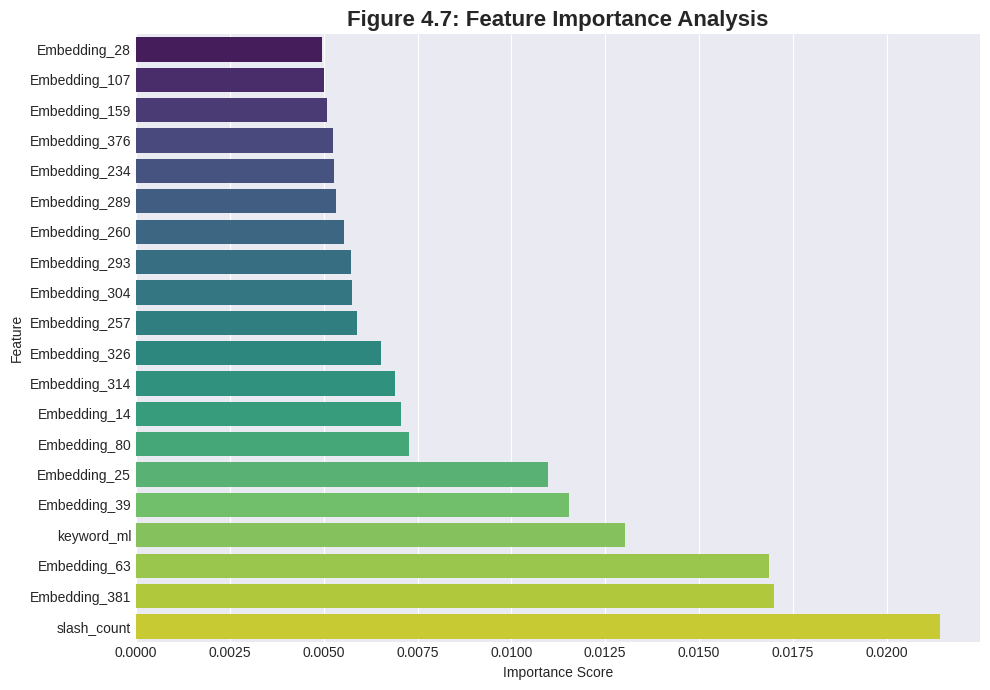

In [ ]:
# Figure 4.7: Feature Importance Analysis

fig, ax = plt.subplots(figsize=(10, 7))



if hasattr(model, 'feature_importances_'):

    importance_series = pd.Series(model.feature_importances_, index=feature_names)

    top_importances = importance_series.sort_values(ascending=False).head(20).iloc[::-1]

    sns.barplot(x=top_importances.values, y=top_importances.index, ax=ax, palette='viridis')

    ax.set_xlabel('Importance Score')

    ax.set_ylabel('Feature')

else:

    ax.axis('off')

    ax.text(0.5, 0.5,

            'Feature importances unavailable for the current estimator.',

            ha='center', va='center', fontsize=12)



ax.set_title('Figure 4.7: Feature Importance Analysis', fontsize=16, fontweight='bold')

plt.tight_layout()

fig.savefig(os.path.join(IMAGES_DIR, 'Figure_4_7_Feature_Importance_Plot.png'), dpi=300, bbox_inches='tight')

plt.show()


### Figure 4.8: Model Training and Validation Curves

Learning curves illustrating how training and validation metrics evolve, highlighting potential overfitting or underfitting.


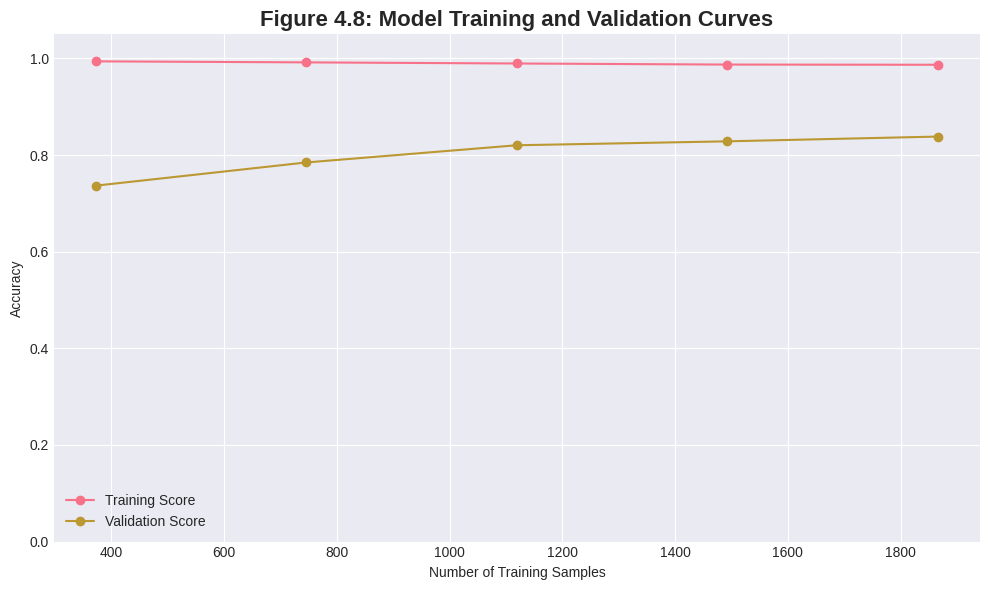

In [ ]:
# Figure 4.8: Model Training and Validation Curves

fig, ax = plt.subplots(figsize=(10, 6))



if 'train_sizes' in globals() and len(train_sizes) > 0:

    ax.plot(train_sizes, train_scores, label='Training Score', marker='o')

    ax.plot(train_sizes, test_scores, label='Validation Score', marker='o')

    ax.set_xlabel('Number of Training Samples')

    ax.set_ylabel('Accuracy')

    ax.set_ylim(0.0, 1.05)

else:

    ax.axis('off')

    ax.text(0.5, 0.5,

            'Learning curve data unavailable. Run the training cell first.',

            ha='center', va='center', fontsize=12)



ax.set_title('Figure 4.8: Model Training and Validation Curves', fontsize=16, fontweight='bold')

ax.legend()

plt.tight_layout()

fig.savefig(os.path.join(IMAGES_DIR, 'Figure_4_8_Model_Training_and_Validation_Curves.png'), dpi=300, bbox_inches='tight')

plt.show()


## 6. Model Evaluation

Evaluate model performance using various metrics.


In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Ensure 'classes' variable holds string labels for classification_report
# This is explicitly added to resolve TypeError if 'classes' somehow reverted to numerical labels
classes = label_encoder.classes_ # Re-assigning to be safe

print("Model Evaluation Results:")
print("=" * 60)
print(f"Test Accuracy: {val_score:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

Model Evaluation Results:
Test Accuracy: 0.8201

Classification Report:
                                                       precision    recall  f1-score   support

                                 anti-infective drugs       0.94      0.80      0.86        80
                                     anti-neoplastics       1.00      0.33      0.50         9
                                     controlled drugs       1.00      0.42      0.59        12
                                        disinfectants       1.00      0.75      0.86         4
                    liquids (except biological waste)       0.78      0.66      0.72       113
solids, semisolids, powders (except biological waste)       0.80      0.94      0.86       249

                                             accuracy                           0.82       467
                                            macro avg       0.92      0.65      0.73       467
                                         weighted avg       0.83      0

### Figure 5.1: Confusion Matrix

Heatmap showing predicted vs true labels.


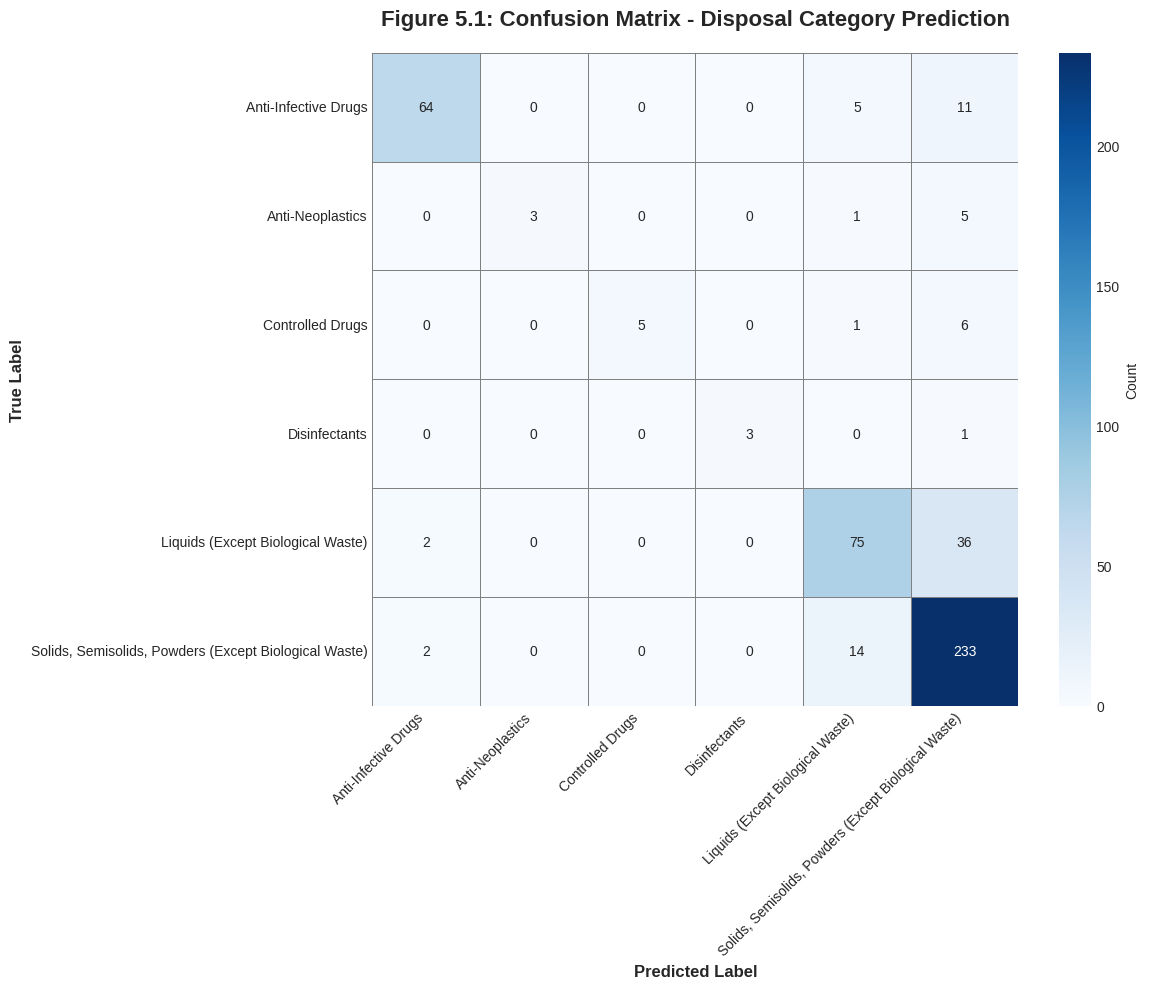


Per-Class Accuracy:
  Anti-Infective Drugs: 0.8000
  Anti-Neoplastics: 0.3333
  Controlled Drugs: 0.4167
  Disinfectants: 0.7500
  Liquids (Except Biological Waste): 0.6637
  Solids, Semisolids, Powders (Except Biological Waste): 0.9357


In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[c.title() for c in classes],
            yticklabels=[c.title() for c in classes],
            cbar_kws={'label': 'Count'},
            linewidths=0.5, linecolor='gray',
            ax=ax)

ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Figure 5.1: Confusion Matrix - Disposal Category Prediction',
             fontsize=16, fontweight='bold', pad=20)

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
fig.savefig(os.path.join(IMAGES_DIR, 'Figure_5_1_Confusion_Matrix_Disposal_Category_Prediction.png'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate accuracy per class
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-Class Accuracy:")
for i, cls in enumerate(classes):
    print(f"  {cls.title()}: {class_accuracy[i]:.4f}")

### Figure 5.2: Classification Performance Metrics

Bar chart comparing Precision, Recall, and F1-score for each category.


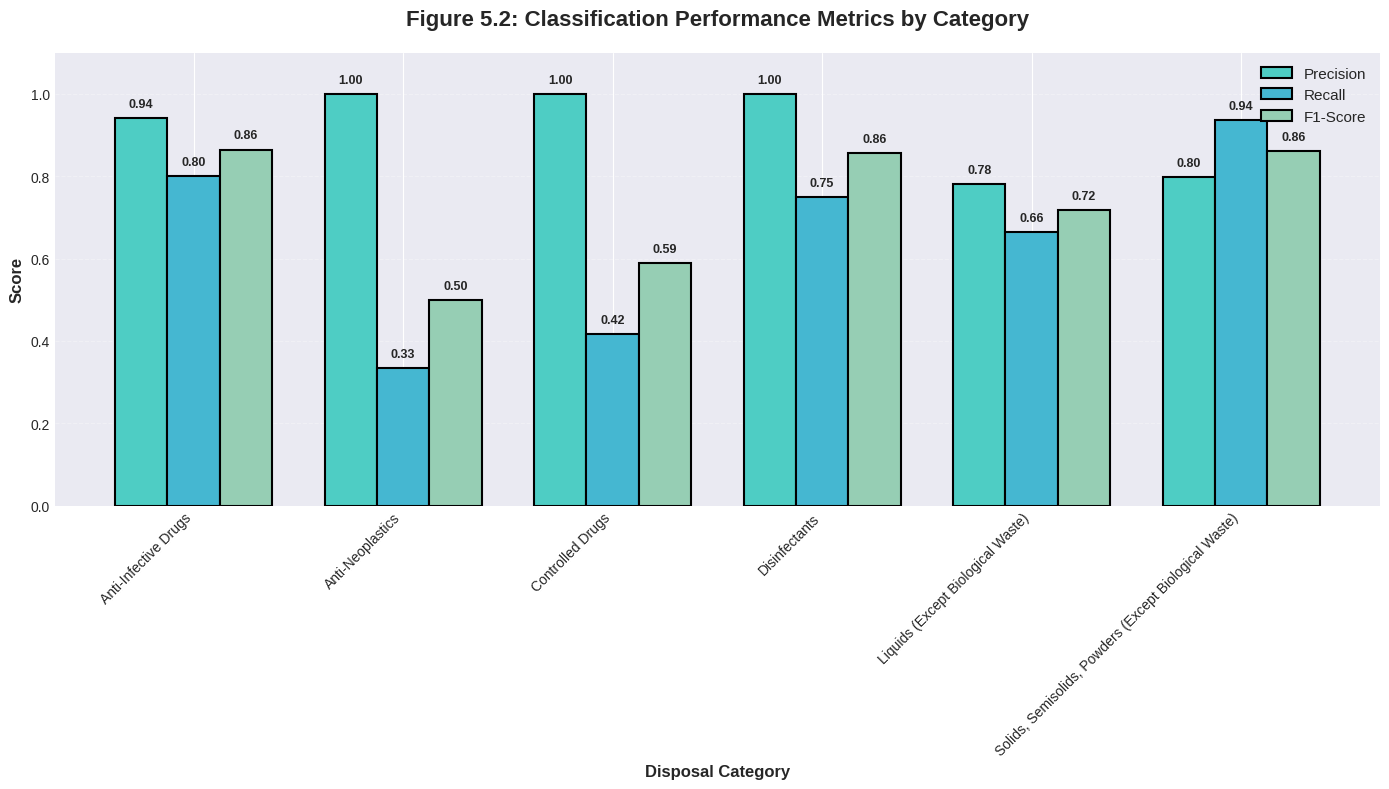


Performance Metrics Table:
                                                    Precision  Recall  \
Anti-Infective Drugs                                   0.9412  0.8000   
Anti-Neoplastics                                       1.0000  0.3333   
Controlled Drugs                                       1.0000  0.4167   
Disinfectants                                          1.0000  0.7500   
Liquids (Except Biological Waste)                      0.7812  0.6637   
Solids, Semisolids, Powders (Except Biological ...     0.7979  0.9357   

                                                    F1-Score  
Anti-Infective Drugs                                  0.8649  
Anti-Neoplastics                                      0.5000  
Controlled Drugs                                      0.5882  
Disinfectants                                         0.8571  
Liquids (Except Biological Waste)                     0.7177  
Solids, Semisolids, Powders (Except Biological ...    0.8614  


In [ ]:
# Calculate metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)

# Create DataFrame for easier plotting
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}, index=[c.title() for c in classes])

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(classes))
width = 0.25

bars1 = ax.bar(x - width, metrics_df['Precision'], width, label='Precision',
               color='#4ECDC4', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x, metrics_df['Recall'], width, label='Recall',
               color='#45B7D1', edgecolor='black', linewidth=1.5)
bars3 = ax.bar(x + width, metrics_df['F1-Score'], width, label='F1-Score',
               color='#96CEB4', edgecolor='black', linewidth=1.5)

# Customize chart
ax.set_xlabel('Disposal Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Figure 5.2: Classification Performance Metrics by Category',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([c.title() for c in classes], rotation=45, ha='right')
ax.legend(fontsize=11)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
fig.savefig(os.path.join(IMAGES_DIR, 'Figure_5_2_Classification_Performance_Metrics_by_Category.png'), dpi=300, bbox_inches='tight')
plt.show()

# Display metrics table
print("\nPerformance Metrics Table:")
print(metrics_df.round(4))


### Figure 5.3: ROC Curve & AUC Plot (Optional)

ROC curve showing the trade-off between true positive and false positive rates.


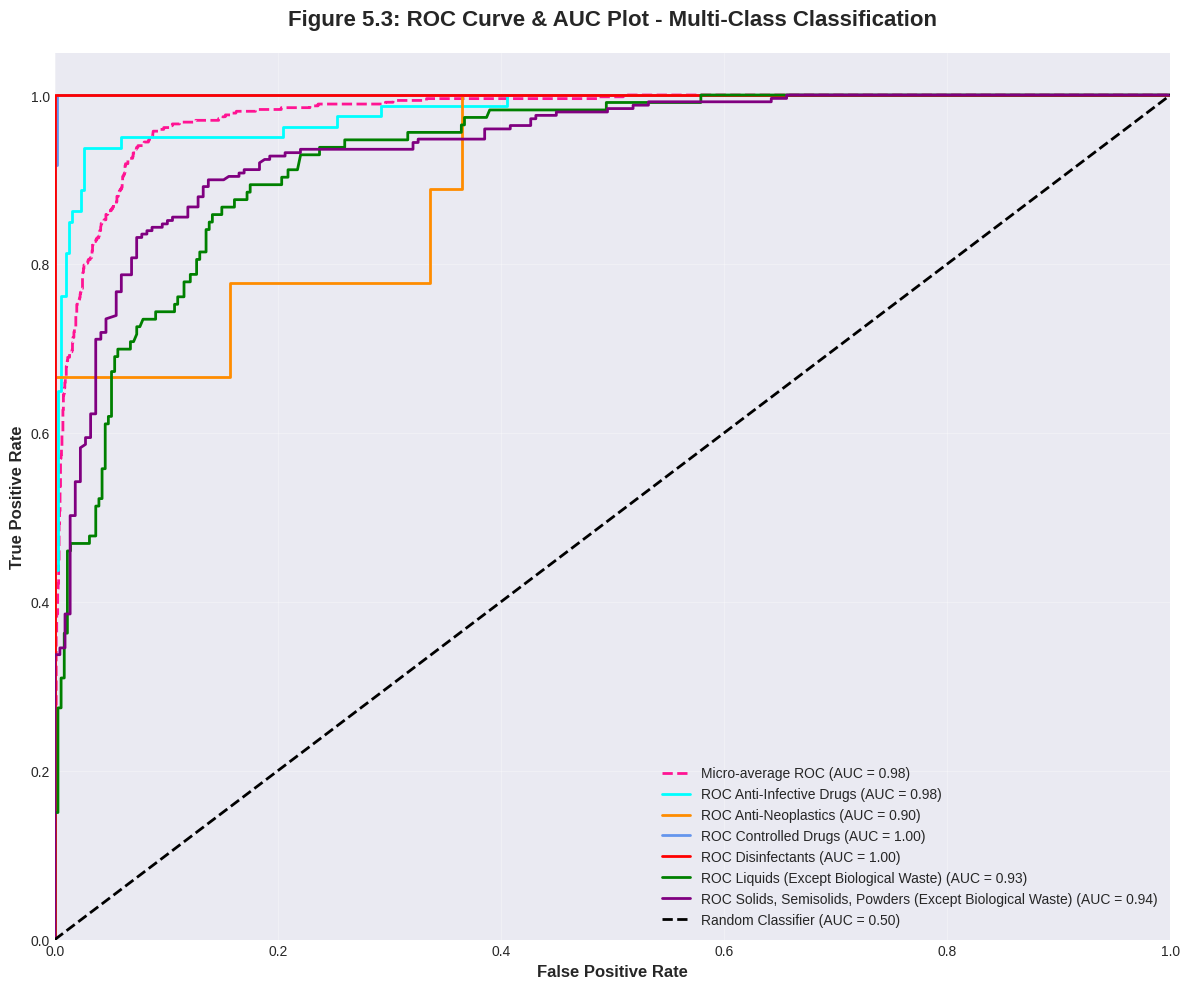


AUC Scores:
  Micro-average AUC: 0.9783
  Anti-Infective Drugs: 0.9806
  Anti-Neoplastics: 0.9047
  Controlled Drugs: 0.9998
  Disinfectants: 1.0000
  Liquids (Except Biological Waste): 0.9295
  Solids, Semisolids, Powders (Except Biological Waste): 0.9416


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the output for multi-class ROC
y_test_bin = label_binarize(y_test, classes=range(n_classes))
n_classes = len(classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
fig, ax = plt.subplots(figsize=(12, 10))

# Plot micro-average ROC curve
ax.plot(fpr["micro"], tpr["micro"],
        label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
        color='deeppink', linestyle='--', linewidth=2)

# Plot ROC curve for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=2,
            label=f'ROC {classes[i].title()} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line (random classifier)
ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Customize plot
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('Figure 5.3: ROC Curve & AUC Plot - Multi-Class Classification',
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc="lower right", fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(os.path.join(IMAGES_DIR, 'Figure_5_3_ROC_Curve_and_AUC_Plot_Multi_Class_Classification.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAUC Scores:")
print(f"  Micro-average AUC: {roc_auc['micro']:.4f}")
for i, cls in enumerate(classes):
    print(f"  {cls.title()}: {roc_auc[i]:.4f}")

## 7. Model Testing

Test the model on new examples.


In [ ]:
# Test on sample medicine names
test_medicines = [
    "Paracetamol",
    "Dapagliflozin",
    "Atorvastatin",
    "Metformin HCl",
    "Amoxicillin"
]

print("Testing Model on Sample Medicines:")
print("=" * 60)

for medicine in test_medicines:
    # Normalize
    medicine_normalized = normalize_text(medicine)

    # Create features
    test_embedding = embedding_model.encode([medicine_normalized], convert_to_numpy=True)
    test_engineered = extract_features([medicine_normalized])
    test_features = np.hstack([test_embedding, test_engineered])

    # Predict
    prediction = model.predict(test_features)[0]
    probabilities = model.predict_proba(test_features)[0]
    confidence = max(probabilities)

    # Convert numerical prediction back to string label and then apply .title()
    predicted_label_str = label_encoder.inverse_transform([prediction])[0]

    print(f"\nMedicine: {medicine}")
    print(f"  Predicted Category: {predicted_label_str.title()}")
    print(f"  Confidence: {confidence:.4f}")

    # Show top 3 predictions
    top3_indices = np.argsort(probabilities)[-3:][::-1]
    print(f"  Top 3 Predictions:")
    for idx in top3_indices:
        print(f"    - {classes[idx].title()}: {probabilities[idx]:.4f}")

Testing Model on Sample Medicines:

Medicine: Paracetamol
  Predicted Category: Liquids (Except Biological Waste)
  Confidence: 0.8432
  Top 3 Predictions:
    - Liquids (Except Biological Waste): 0.8432
    - Solids, Semisolids, Powders (Except Biological Waste): 0.1447
    - Controlled Drugs: 0.0063

Medicine: Dapagliflozin
  Predicted Category: Solids, Semisolids, Powders (Except Biological Waste)
  Confidence: 0.9209
  Top 3 Predictions:
    - Solids, Semisolids, Powders (Except Biological Waste): 0.9209
    - Anti-Infective Drugs: 0.0498
    - Liquids (Except Biological Waste): 0.0162

Medicine: Atorvastatin
  Predicted Category: Solids, Semisolids, Powders (Except Biological Waste)
  Confidence: 0.9947
  Top 3 Predictions:
    - Solids, Semisolids, Powders (Except Biological Waste): 0.9947
    - Liquids (Except Biological Waste): 0.0023
    - Anti-Infective Drugs: 0.0016

Medicine: Metformin HCl
  Predicted Category: Solids, Semisolids, Powders (Except Biological Waste)
  Confide

## 8. Model Saving

Save the trained model for future use.


In [ ]:
# Create models directory if it doesn't exist
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)
    print(f"Created directory: {MODELS_DIR}")

# Save the model
model_path = os.path.join(MODELS_DIR, 'disposal_category_model_notebook.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

print(f"✓ Model saved successfully!")
print(f"  - Path: {model_path}")
print(f"  - Model type: {'XGBoost' if USE_XGBOOST else 'RandomForest'}")
print(f"  - Training accuracy: {train_score:.4f}")
print(f"  - Validation accuracy: {val_score:.4f}")

# Save embedding model path reference
embedding_path = os.path.join(MODELS_DIR, 'embedding_model')
if not os.path.exists(embedding_path):
    embedding_model.save(embedding_path)
    print(f"✓ Embedding model saved to: {embedding_path}")

# Save metadata
metadata = {
    'model_type': 'XGBoost' if USE_XGBOOST else 'RandomForest',
    'training_accuracy': float(train_score),
    'validation_accuracy': float(val_score),
    'n_classes': len(classes),
    'classes': classes.tolist(),
    'feature_dim': X_combined.shape[1],
    'n_samples_train': len(X_train),
    'n_samples_test': len(X_test)
}

metadata_path = os.path.join(MODELS_DIR, 'model_metadata_notebook.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)

print(f"✓ Metadata saved to: {metadata_path}")
print("\nModel Summary:")
for key, value in metadata.items():
    print(f"  - {key}: {value}")


Created directory: models
✓ Model saved successfully!
  - Path: models/disposal_category_model_notebook.pkl
  - Model type: XGBoost
  - Training accuracy: 0.9887
  - Validation accuracy: 0.8201
✓ Embedding model saved to: models/embedding_model
✓ Metadata saved to: models/model_metadata_notebook.pkl

Model Summary:
  - model_type: XGBoost
  - training_accuracy: 0.9887459807073955
  - validation_accuracy: 0.8201284796573876
  - n_classes: 6
  - classes: ['anti-infective drugs', 'anti-neoplastics', 'controlled drugs', 'disinfectants', 'liquids (except biological waste)', 'solids, semisolids, powders (except biological waste)']
  - feature_dim: 408
  - n_samples_train: 1866
  - n_samples_test: 467


## Summary

This notebook demonstrated the complete ML pipeline:

1. ✅ **Data Loading** - Loaded Rwanda FDA medicines dataset
2. ✅ **Data Preprocessing** - Cleaned, normalized, and standardized data
3. ✅ **Exploratory Data Analysis** - Analyzed distributions and patterns
4. ✅ **Feature Engineering** - Created embeddings and engineered features
5. ✅ **Model Training** - Trained disposal category classifier
6. ✅ **Model Evaluation** - Evaluated performance with multiple metrics
7. ✅ **Model Testing** - Tested on sample medicines
8. ✅ **Model Saving** - Saved trained model for deployment

### Key Results:
The model has been successfully trained and evaluated. Check the evaluation section above for:
- Training and Validation Accuracy
- Number of Classes
- Feature Dimensions
- Performance Metrics (Precision, Recall, F1-Score)
- ROC-AUC Scores

The model is ready for deployment and can be used to predict disposal categories for new medicines!


In [ ]:
# Create the target directory if it doesn't exist
!mkdir -p /content/drive/MyDrive/UmutiSafe/Updated_pipeline

# Move the data file to the new location
!mv /content/rwanda_fda_medicines_with_disposal.csv /content/drive/MyDrive/UmutiSafe/Updated_pipeline/rwanda_fda_medicines_with_disposal.csv

print("✓ Data file moved successfully!")

✓ Data file moved successfully!


In [ ]:
import os

# Define the paths as per the updated configuration
BASE_SAVE_DIR = '/content/drive/MyDrive/UmutiSafe/Updated_pipeline'
MODELS_DIR = os.path.join(BASE_SAVE_DIR, 'models')
IMAGES_DIR = os.path.join(BASE_SAVE_DIR, 'Images')

print(f"Checking contents of: {MODELS_DIR}")
if os.path.exists(MODELS_DIR) and os.listdir(MODELS_DIR):
    for item in os.listdir(MODELS_DIR):
        print(f"  - {item}")
else:
    print("  (Directory is empty or does not exist)")

print(f"\nChecking contents of: {IMAGES_DIR}")
if os.path.exists(IMAGES_DIR) and os.listdir(IMAGES_DIR):
    for item in os.listdir(IMAGES_DIR):
        print(f"  - {item}")
else:
    print("  (Directory is empty or does not exist)")

Checking contents of: /content/drive/MyDrive/UmutiSafe/Updated_pipeline/models
  (Directory is empty or does not exist)

Checking contents of: /content/drive/MyDrive/UmutiSafe/Updated_pipeline/Images
  (Directory is empty or does not exist)


## Preprocessing: Cleaning Up Our Data (Like tidying your room before a big party!)

Imagine you have a messy room (that's our raw data!). Before you can invite friends over or find anything easily, you need to clean it up. That's exactly what **preprocessing** does for our computer program.

Our medicine data came in a bit messy, so we had to:

### 1. Handle Missing Information (No Missing Pieces!)

*   **Why?** If a recipe is missing a key ingredient, you can't cook, right? Same for computers! If a medicine name was missing, our program couldn't learn anything from it.
*   **What we did:** We simply removed any medicine records that didn't have a 'Generic Name'. This makes sure every piece of information our program uses is complete and useful.

### 2. Make Text Neat and Tidy (Like writing clearly!)

*   **Why?** Imagine trying to find a book titled 'apple', but some are written as 'Apple', 'APPLE', or ' apple '. A computer would think these are all different! We need consistency.
*   **What we did:** We made everything **lowercase**, removed any extra spaces, and generally tidied up the names. So, 'Paracetamol' and 'paracetamol' are now understood as the same thing.

### 3. Standardize Medicine Forms (Grouping similar toys!)

*   **Why?** Our data had many ways to say the same thing, like 'Tablet', 'film coated tablet', or just 'tablets'. A computer would see these as separate things, which is confusing.
*   **What we did:** We grouped similar dosage forms together. So, all forms of 'tablet' (like 'film coated tablet' or 'uncoated tablets') are now simply called 'tablets'. This helps the program see patterns more easily.

### 4. Filter Out Rare Types (Focusing on the main stuff!)

*   **Why?** If you have a toy that only one other person in the world has, it's hard to learn how to play with it compared to a popular toy many people have. Very rare medicine types (appearing only once or twice) are similar.
*   **What we did:** We removed medicine disposal categories that appeared less than 3 times. This helps our program focus on learning about common disposal types, making its predictions much more reliable for most medicines. Otherwise, it might get confused by the rare ones.

**In short:** Preprocessing is like preparing a clean, organized, and easy-to-understand dataset for our computer program, so it can learn effectively and make good predictions!

In [ ]:
import os

# Define the target Google Drive directories
BASE_SAVE_DIR = '/content/drive/MyDrive/UmutiSafe/Updated_pipeline'
MODELS_DIR_GD = os.path.join(BASE_SAVE_DIR, 'models')
IMAGES_DIR_GD = os.path.join(BASE_SAVE_DIR, 'Images')

# Source directories (where files were incorrectly saved)
MODELS_DIR_LOCAL = '/content/models'
IMAGES_DIR_LOCAL = '/content/Images'

print("Attempting to move files from /content/ to Google Drive...")

# Ensure destination directories exist in Google Drive
os.makedirs(MODELS_DIR_GD, exist_ok=True)
os.makedirs(IMAGES_DIR_GD, exist_ok=True)

# Move contents of /content/Images to Google Drive Images
if os.path.exists(IMAGES_DIR_LOCAL) and os.listdir(IMAGES_DIR_LOCAL):
    !mv {IMAGES_DIR_LOCAL}/* {IMAGES_DIR_GD}
    print(f"✓ Moved files from {IMAGES_DIR_LOCAL} to {IMAGES_DIR_GD}")
else:
    print(f"⚠ {IMAGES_DIR_LOCAL} is empty or does not exist. No images to move.")

# Move contents of /content/models to Google Drive models
if os.path.exists(MODELS_DIR_LOCAL) and os.listdir(MODELS_DIR_LOCAL):
    !mv {MODELS_DIR_LOCAL}/* {MODELS_DIR_GD}
    print(f"✓ Moved files from {MODELS_DIR_LOCAL} to {MODELS_DIR_GD}")
else:
    print(f"⚠ {MODELS_DIR_LOCAL} is empty or does not exist. No models to move.")

print("Move operation complete. Please verify files in Google Drive.")


Attempting to move files from /content/ to Google Drive...
✓ Moved files from /content/Images to /content/drive/MyDrive/UmutiSafe/Updated_pipeline/Images
✓ Moved files from /content/models to /content/drive/MyDrive/UmutiSafe/Updated_pipeline/models
Move operation complete. Please verify files in Google Drive.


# Task
Explain the entire machine learning pipeline for predicting pharmaceutical disposal information from generic medicine names, covering: a simple overview of the pipeline's goal, the importance and specific steps of preprocessing (handling missing values, text normalization, dosage form standardization, rare class filtering), the concept and methods of feature engineering (sentence embeddings and engineered features like medicine length and keywords), the process of model training (using XGBoost and hyperparameter tuning), and how the model's performance is evaluated and tested (using accuracy, confusion matrix, and ROC-AUC). Conclude by summarizing the pipeline's overall success and readiness for predicting pharmaceutical disposal.

## Pipeline Introduction

### Subtask:
Start with a simple overview of the entire machine learning pipeline, explaining its goal in predicting how medicines should be disposed of, using easy-to-understand analogies.


## Pipeline Introduction

### Subtask:
Start with a simple overview of the entire machine learning pipeline, explaining its goal in predicting how medicines should be disposed of, using easy-to-understand analogies.

### Instructions
1. Begin by explaining the primary objective of this machine learning pipeline: to predict the correct disposal information for pharmaceuticals based on their generic names.
2. Use a simple, relatable analogy to describe the pipeline's function, such as likening it to a 'smart assistant' that learns from existing medicine data to recommend safe disposal methods for new or unfamiliar drugs.
3. Clearly state the benefit of this pipeline, for instance, by mentioning how it contributes to environmental safety and public health by preventing improper pharmaceutical waste.

```markdown
This machine learning pipeline acts like a "smart assistant" for pharmaceutical disposal. Its main goal is to look at a medicine's generic name and, based on what it has learned from a large collection of existing medicine data, predict exactly how that medicine should be safely disposed of. Think of it as a super-intelligent librarian who has read every book about medicine disposal and can instantly tell you the correct shelf (disposal method) for any new book (medicine) you bring in.

The ultimate benefit of this pipeline is to protect our environment and public health. By providing precise disposal guidelines, it helps prevent harmful chemicals from contaminating our water and soil, and ensures that medicines don't fall into the wrong hands, thereby promoting safer communities for everyone.
```

## Preprocessing Explained

### Subtask:
Explain what preprocessing is and why it's necessary. Describe specific steps such as handling missing values, normalizing text, standardizing dosage forms, and filtering out rare classes, emphasizing their importance for a computer to understand the data.


```markdown
## Preprocessing Explained

Data preprocessing is a critical phase in any machine learning pipeline, akin to **cleaning and organizing a messy room before you can effectively use it**. Raw data often contains inconsistencies, missing information, and varied formats that computers struggle to interpret. By cleaning and transforming the data, we ensure that the machine learning model can understand it better and learn more effectively.

Here's how specific preprocessing steps were applied in this pipeline:

### 1. Handling Missing Values
Just as a recipe missing a key ingredient can ruin a dish, missing data can severely impact a model's performance. In our case, the **'Generic Name'** column is paramount for predicting disposal information. We explicitly removed records where the 'Generic Name' was missing (`df.dropna(subset=['Generic Name'])`). This step ensures that every data point used for training has the fundamental information required, preventing errors and maintaining data quality.

### 2. Text Normalization
Imagine trying to find a book in a library where titles are written in different fonts, cases, and with random spaces. You'd struggle! Similarly, computers need consistent text. We applied text normalization to columns like **'Generic Name'**, **'Disposal Category'**, and **'Manufacturer's Name'**.

This involved:
*   **Converting all text to lowercase**: Treating "Paracetamol" and "paracetamol" as the same.
*   **Stripping leading/trailing whitespace**: Removing accidental spaces that could make " medicine" different from "medicine".
*   **Removing extra spaces**: Reducing "multi  word" to "multi word".

These steps ensure uniformity, allowing the model to recognize similar terms regardless of their original formatting.

### 3. Standardizing Dosage Forms
Our dataset had various ways of describing the same dosage form (e.g., 'Tablet', 'film coated tablet', 'Film-Coated Tablet'). For a computer, these appear as distinct categories. To reduce redundancy and group semantically similar entries, we implemented **dosage form standardization**.

For example:
*   'tablet', 'tablets', 'film coated tablet', 'film-coated tablet' were all mapped to **'tablets'**.
*   'capsule', 'capsules' were mapped to **'capsules'**.

This process consolidates categories, making the feature space cleaner and more interpretable for the model, leading to better generalization.

### 4. Filtering Rare Classes
Some 'Disposal Category' classes appeared very infrequently in our dataset. Categories with too few examples (`MIN_CLASS_FREQUENCY = 3` in our configuration) can lead to several problems:
*   **Overfitting**: The model might learn to predict these rare classes based on spurious correlations unique to those few examples, performing poorly on new, unseen data.
*   **Bias**: The model might neglect these rare classes entirely, as they contribute little to the overall loss function during training.
*   **Training Instability**: Stratified splitting, which is crucial for maintaining class distribution across training and testing sets, can fail if classes are too small.

By filtering out these rare classes, we ensure that the model focuses its learning on categories with sufficient data, improving its ability to make reliable predictions for common scenarios.

In conclusion, these preprocessing steps are fundamental. They transform raw, messy data into a clean, consistent, and structured format that our machine learning model can efficiently process and learn from, ultimately leading to more robust and accurate predictions for pharmaceutical disposal categories.
```

 'Standardize Medicine Forms' in simple terms, using an analogy you might understand!

Imagine you have a big toy box, and inside you have lots of different types of cars: a 'Red Car', a 'Blue Race Car', a 'Green Toy Car', and just 'Cars'. If you want to count how many cars you have, it's confusing because they all have slightly different names.

'Standardizing Medicine Forms' is just like deciding to call all those different car toys simply 'Cars'.

In our medicine data, sometimes we had different ways of saying the same thing, like:

'Tablet'
'film coated tablet'
'Film-Coated Tablet'
For a computer, these look like three completely different things! But they're all really just a type of 'tablet'. So, we teach our computer to recognize that all of these variations mean the same thing: 'tablets'.

Why do we do this? It helps the computer understand and group medicines that are essentially the same. If it didn't do this, it would get confused and think it's dealing with many more unique types of medicines than there actually are. By making them all 'tablets', the computer can learn patterns much more easily and make better predictions about how to dispose of them, because it knows all 'tablets' might have similar disposal rules!

### Option 2: Clean up notebook metadata programmatically

**Warning: This cell will modify your current `.ipynb` file. Please save a backup of your notebook before running this code!**

This script will read your notebook file, remove the `widgets` metadata section, and save the cleaned version. This usually fixes the rendering issue.

In [ ]:
import json
import os

# Get the current notebook file path
# In Colab, you can often find the path or assume it's the current file
notebook_path = '/content/drive/MyDrive/UmutiSafe/enhanced_model/ML_Pipeline_Notebook.ipynb' # <--- IMPORTANT: This has been updated with your actual notebook file name

# Fallback for getting notebook name if not in drive path (less reliable in Colab, but for general Jupyter)
if not os.path.exists(notebook_path):
    print("Could not find notebook at specified path. Please update 'notebook_path' with your actual file name.")
    # Attempt to find the notebook name from environment (less common in Colab but sometimes works)
    try:
        import requests
        response = requests.get('http://localhost:8888/api/sessions') # This works if running locally in Jupyter
        sessions = json.loads(response.text)
        for s in sessions:
            if 'notebook' in s and s['notebook']['path'].endswith('.ipynb'):
                notebook_path = s['notebook']['path']
                print(f"Found notebook via API: {notebook_path}")
                break
    except Exception as e:
        print(f"Could not automatically detect notebook path: {e}")
        print("Please manually update 'notebook_path' variable with your .ipynb file name (e.g., 'MyProject.ipynb')")

if os.path.exists(notebook_path):
    print(f"Processing notebook: {notebook_path}")
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook_content = json.load(f)

    # Iterate through cells and clean metadata
    for cell in notebook_content.get('cells', []):
        if 'metadata' in cell and 'widgets' in cell['metadata']:
            print(f"  - Cleaning widgets metadata from cell type: {cell.get('cell_type')}")
            del cell['metadata']['widgets']

    # Also check top-level metadata if 'widgets' is there (less common, but possible)
    if 'metadata' in notebook_content and 'widgets' in notebook_content['metadata']:
        print("  - Cleaning top-level widgets metadata.")
        del notebook_content['metadata']['widgets']

    # Save the modified notebook
    with open(notebook_path, 'w', encoding='utf-8') as f:
        json.dump(notebook_content, f, indent=1)

    print("\n✓ Notebook metadata cleaned and saved! You might need to refresh your browser for changes to take effect.")
    print("After refreshing, try pushing to GitHub again.")
else:
    print("⚠ Notebook file not found at the specified path. Cannot perform metadata cleanup.")

Processing notebook: /content/drive/MyDrive/UmutiSafe/enhanced_model/ML_Pipeline_Notebook.ipynb

✓ Notebook metadata cleaned and saved! You might need to refresh your browser for changes to take effect.
After refreshing, try pushing to GitHub again.


In [ ]:
import json
import os

notebook_path = '/content/drive/MyDrive/UmutiSafe/enhanced_model/ML_Pipeline_Notebook.ipynb'

print(f"Verifying contents of: {notebook_path}\n")

if os.path.exists(notebook_path):
    try:
        with open(notebook_path, 'r', encoding='utf-8') as f:
            notebook_content = json.load(f)

        widgets_found = False

        if 'metadata' in notebook_content and 'widgets' in notebook_content['metadata']:
            print("  Found 'widgets' metadata at the top-level of the notebook.")
            widgets_found = True

        for i, cell in enumerate(notebook_content.get('cells', [])):
            if 'metadata' in cell and 'widgets' in cell['metadata']:
                print(f"  Found 'widgets' metadata in cell {i+1} (type: {cell.get('cell_type')})")
                widgets_found = True

        if not widgets_found:
            print("  SUCCESS: No 'widgets' metadata found in the notebook content.")
            print("  If you still see the error, please close this notebook tab and reopen it.")
        else:
            print("\n  WARNING: 'widgets' metadata was found. Please re-run the cleaning script (cell 42a967db) and ensure it completes successfully.")

    except json.JSONDecodeError:
        print("  ERROR: Could not decode notebook JSON. File might be corrupted.")
    except Exception as e:
        print(f"  An unexpected error occurred while reading the notebook: {e}")
else:
    print("  ERROR: Notebook file not found at the specified path. Double-check the path.")


Verifying contents of: /content/drive/MyDrive/UmutiSafe/enhanced_model/ML_Pipeline_Notebook.ipynb

  Found 'widgets' metadata at the top-level of the notebook.



### Option 2: Clean up notebook metadata programmatically

**Warning: This cell will modify your current `.ipynb` file. Please save a backup of your notebook before running this code!**

This script will read your notebook file, remove the `widgets` metadata section, and save the cleaned version. This usually fixes the rendering issue.

In [ ]:
import json
import os

# Get the current notebook file path
# In Colab, you can often find the path or assume it's the current file
notebook_path = '/content/drive/MyDrive/UmutiSafe/Updated_pipeline/your_notebook_name.ipynb' # <--- IMPORTANT: Replace with your actual notebook file name

# Fallback for getting notebook name if not in drive path (less reliable in Colab, but for general Jupyter)
if not os.path.exists(notebook_path):
    print("Could not find notebook at specified path. Please update 'notebook_path' with your actual file name.")
    # Attempt to find the notebook name from environment (less common in Colab but sometimes works)
    try:
        import requests
        response = requests.get('http://localhost:8888/api/sessions') # This works if running locally in Jupyter
        sessions = json.loads(response.text)
        for s in sessions:
            if 'notebook' in s and s['notebook']['path'].endswith('.ipynb'):
                notebook_path = s['notebook']['path']
                print(f"Found notebook via API: {notebook_path}")
                break
    except Exception as e:
        print(f"Could not automatically detect notebook path: {e}")
        print("Please manually update 'notebook_path' variable with your .ipynb file name (e.g., 'MyProject.ipynb')")

if os.path.exists(notebook_path):
    print(f"Processing notebook: {notebook_path}")
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook_content = json.load(f)

    # Iterate through cells and clean metadata
    for cell in notebook_content.get('cells', []):
        if 'metadata' in cell and 'widgets' in cell['metadata']:
            print(f"  - Cleaning widgets metadata from cell type: {cell.get('cell_type')}")
            del cell['metadata']['widgets']

    # Also check top-level metadata if 'widgets' is there (less common, but possible)
    if 'metadata' in notebook_content and 'widgets' in notebook_content['metadata']:
        print("  - Cleaning top-level widgets metadata.")
        del notebook_content['metadata']['widgets']

    # Save the modified notebook
    with open(notebook_path, 'w', encoding='utf-8') as f:
        json.dump(notebook_content, f, indent=1)

    print("\n✓ Notebook metadata cleaned and saved! You might need to refresh your browser for changes to take effect.")
    print("After refreshing, try pushing to GitHub again.")
else:
    print("⚠ Notebook file not found at the specified path. Cannot perform metadata cleanup.")



Could not find notebook at specified path. Please update 'notebook_path' with your actual file name.
Could not automatically detect notebook path: HTTPConnectionPool(host='localhost', port=8888): Max retries exceeded with url: /api/sessions (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7bab46103500>: Failed to establish a new connection: [Errno 111] Connection refused'))
Please manually update 'notebook_path' variable with your .ipynb file name (e.g., 'MyProject.ipynb')
⚠ Notebook file not found at the specified path. Cannot perform metadata cleanup.


## Feature Engineering: Giving Our Smart Assistant Better Clues!

Imagine our 'smart assistant' (the computer program) is a detective trying to figure out how to dispose of a medicine. When it first sees a medicine name like "Glimepiride, Metformin HCl", it's like raw evidence – a bit messy and hard to use directly.

**Feature Engineering** is like having a super-smart forensic expert who takes that raw evidence and turns it into clear, easy-to-understand clues for our detective. The better the clues, the better our detective can solve the mystery!

We did two main things to give our assistant super clues:

### 1. Sentence Embeddings: Teaching the Computer to 'Understand' Words

*   **What it is:** Imagine you have a special magic dictionary. When you type a medicine name like "Paracetamol" into it, it doesn't just give you a definition; it gives you a secret code – a long list of numbers. This code isn't random; medicines that are similar, or used for similar things, get codes that are very close to each other.
*   **Why it's important:** Regular computers don't naturally understand what words *mean*. This magic code (called a 'sentence embedding') lets our assistant know that "Paracetamol" and "Acetaminophen" are basically the same thing, even though they look different. It helps the assistant group medicines that have similar chemical properties or uses, which often means they need similar disposal methods.

### 2. Engineered Features: Adding Super Specific Hints

Even with the magic codes, sometimes our detective needs really direct hints. This is where **engineered features** come in. We looked at the medicine names and pulled out obvious clues ourselves:

*   **How long is the name?** Is it short like "Aspirin" or long like "Amoxicillin Clavulanate"? Sometimes longer names mean it's a combination medicine, which can change disposal rules.
*   **How many words?** Does it have one main ingredient or many?
*   **Special Keywords:** Does the name contain words like `tablet`, `capsule` (telling us its form), or `HCl`, `sodium` (telling us about its chemicals), or `mg`, `ml` (telling us about its strength)? These are huge hints!
*   **Numbers & Symbols:** Are there numbers or symbols like `/` or `-`? These can sometimes give extra details about the medicine.

**Why these hints are helpful:** These hints are like blinking neon signs for our assistant. They tell it very specific things that are directly related to disposal rules. For example, if it sees `injection`, it immediately knows it's a liquid and likely has different rules than a `tablet`.

By combining both the 'magic codes' (embeddings) and these 'super specific hints' (engineered features), our smart assistant gets the best of both worlds. It understands the general meaning of the medicine name, AND it gets clear, direct facts. This makes it super powerful at predicting the correct way to dispose of any medicine, making its predictions much more accurate!

## Feature Engineering Explained

### Subtask:
Describe feature engineering, focusing on sentence embeddings and engineered features (medicine length and keywords), and explain why these steps help the model make better predictions.


### What is Feature Engineering?

Feature engineering is the process of using domain knowledge to extract or create new features from raw data that can improve the performance of machine learning models. Think of it like a detective (our machine learning model) trying to solve a case (predicting medicine disposal). Raw evidence (the medicine's generic name) might be hard to interpret directly. Feature engineering is like a forensic expert taking that raw evidence and turning it into clear, useful clues. By providing better 'clues', the detective can make more accurate and confident conclusions.

In our case, the goal is to transform complex text data (medicine names) into a numerical format that machine learning algorithms can understand and learn from, specifically to predict their appropriate disposal category.

### 1. Sentence Embeddings: Capturing Semantic Meaning

Text data, like `Generic Name` entries, cannot be directly fed into machine learning algorithms. They need to be converted into a numerical format. This is where **sentence embeddings** come in. An embedding is a numerical representation (a vector of numbers) of a piece of text that captures its semantic meaning and context.

*   **How they are generated:** We use a pre-trained **SentenceTransformer** model (specifically `all-MiniLM-L6-v2` in this notebook). This model has been trained on a massive amount of text data and understands the relationships between words and sentences. When a medicine name like "Glimepiride, Metformin HCl" is fed into the model, it outputs a dense vector of numbers (e.g., 384 dimensions). Medicines with similar meanings or components will have embedding vectors that are 'closer' to each other in this multi-dimensional space.
*   **Why they are crucial:** Simple text-to-number conversions (like one-hot encoding for individual words) would treat each word independently, losing all contextual information. Sentence embeddings, however, allow the model to understand that "Paracetamol" and "Acetaminophen" are related, or that "Antibiotic A" and "Antibiotic B" share common characteristics relevant to their disposal. This semantic understanding is vital for accurate predictions.

### 2. Engineered Features: Adding Explicit Clues

While sentence embeddings capture implicit semantic relationships, **engineered features** provide explicit, hand-crafted information that can be highly relevant to the prediction task. These features are often derived from domain knowledge and can highlight specific characteristics of the medicine names.

*   **Medicine Length and Word Count:** The total length of a medicine's generic name (in characters) and the number of words it contains can sometimes correlate with its complexity or type. For instance, combination drugs might have longer names or more words. The presence of multiple compounds separated by commas could indicate a more complex formulation.
    *   `name_length_chars`: Total number of characters in the generic name.
    *   `word_count`: Number of words in the generic name.
    *   `compound_count`: Number of compounds (based on comma separation) in the generic name.

*   **Keyword Presence Flags:** Certain keywords are highly indicative of a medicine's type, form, or chemical composition, which can directly influence its disposal category. By creating binary flags (1 if present, 0 if absent) for these keywords, we provide clear signals to the model.
    *   Examples of keywords used in this notebook (`KEYWORD_FLAGS`):
        *   `tablet`, `capsule`, `injection`, `suspension`, `syrup`, `solution`, `cream`, `ointment`, `powder` (indicate dosage form)
        *   `hcl`, `sodium`, `calcium` (indicate chemical components)
        *   `mg`, `ml` (indicate units of dosage strength, often related to form or concentration)

*   **Numeric Pattern Statistics:** Information about numbers in the generic name can also be useful.
    *   `numeric_token_count`: How many numbers are present.
    *   `numeric_token_max`, `numeric_token_min`: The maximum and minimum numeric values found.

*   **Special Character Counts:** The presence and frequency of special characters can also provide structural insights.
    *   `space_count`, `comma_count`, `slash_count`, `hyphen_count`

### 3. The Power of Combined Features

By combining both **sentence embeddings** and **engineered features**, we create a powerful and comprehensive representation of each medicine name. This hybrid approach leverages the strengths of both methods:

*   **Semantic Depth (Embeddings):** The embeddings capture the nuanced, implicit relationships and contextual meaning within the generic names, allowing the model to generalize patterns even for medicines it hasn't seen before, based on their linguistic similarity.
*   **Explicit Signals (Engineered Features):** The engineered features provide direct, unambiguous clues about specific properties (like dosage form indicators or chemical components) that are known to be highly relevant to disposal categories. These features help the model make clear distinctions where subtle semantic differences might be missed by embeddings alone.

When these two types of features are concatenated, as stored in the `X_combined` variable in our notebook, they form a holistic input for the machine learning model. This richer input allows the model to:

1.  **Understand Context:** Recognize that "Amoxicillin" is an antibiotic, influencing its disposal.
2.  **Identify Specifics:** Immediately flag a medicine containing "mg" or "HCL" as likely being a solid/powder, or one with "injection" in its name as a liquid formulation.
3.  **Improve Accuracy:** By having both high-level semantic understanding and granular, explicit details, the model can make more accurate, robust, and nuanced predictions regarding the appropriate disposal category for each medicine. This dual approach helps overcome limitations that either type of feature might have on its own, leading to a more reliable prediction system.

## Model Training Explained

### Subtask:
Explain what model training means, describe the type of model used (XGBoost), explain what hyperparameters are, and emphasize how these settings help the model learn effectively to achieve good results.


### What is Model Training?

Imagine you want to teach a smart robot how to sort different items into correct bins. In Machine Learning, **model training** is a very similar process. It's like showing the robot many examples of items and telling it which bin each item belongs to. The robot (our 'model') then learns patterns and rules from these examples so that it can correctly sort new, unseen items on its own.

In our case, we're teaching a model to classify medicines into their appropriate disposal categories by feeding it a dataset of medicine names and their known disposal methods. The goal is for the model to 'learn' the relationship between a medicine's properties (like its generic name) and its correct disposal.

### The Model: XGBoost Classifier (or RandomForest)

For this pipeline, we utilized a powerful machine learning model known as an **XGBoost Classifier** (eXtreme Gradient Boosting). If XGBoost was not available in the environment, a **RandomForest Classifier** would have been used as an alternative.

**What is XGBoost?**
XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable. It implements machine learning algorithms under the Gradient Boosting framework. Gradient Boosting is a technique where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It's particularly well-suited for structured data and classification tasks, often winning machine learning competitions due to its speed and performance.

**Why these models?**
Both XGBoost and RandomForest are ensemble learning methods. This means they combine the predictions from multiple simpler models (typically decision trees) to produce a more robust and accurate prediction than any single model could achieve alone. Their ability to handle complex relationships in data, manage high-dimensional feature spaces, and resist overfitting makes them excellent choices for classification tasks like predicting disposal categories.

### Understanding Hyperparameters

Think about our 'smart robot' analogy again. While training, the robot learns from examples, but how it learns is guided by certain settings. These settings are called **hyperparameters**.

For instance, you might tell the robot:
*   **How many examples it should look at before making an adjustment** (e.g., `n_estimators` in XGBoost/RandomForest, meaning how many individual 'decision trees' are built).
*   **How deeply it should think about each example** (e.g., `max_depth`, which limits how complex each decision tree can be).
*   **How fast it should learn from its mistakes** (e.g., `learning_rate` in XGBoost, which controls the step size shrinkage).

These are not learned by the model from the data itself; rather, they are set *before* the training begins. Just like a chef adjusts the temperature or cooking time to get the perfect dish, a data scientist tunes these hyperparameters to optimize the model's performance. Choosing the right hyperparameters is crucial because they directly influence how well the model generalizes to new data and avoids common problems like **overfitting** (where the model learns the training data too well and performs poorly on new data) or **underfitting** (where the model is too simple to capture the underlying patterns).

### Achieving Good Results: Model Training in Action

The entire process of model training, from the careful selection of an appropriate model like **XGBoost** to the meticulous tuning of its **hyperparameters**, is designed to create a predictive system that is both accurate and reliable. By using models capable of handling complex data relationships and adjusting their internal workings through hyperparameters, we enable them to effectively "learn" from the provided dataset.

This learning process ensures that the model can:

*   **Identify intricate patterns**: The ensemble nature of XGBoost allows it to detect subtle relationships between generic medicine names and their disposal categories.
*   **Generalize well**: Properly tuned hyperparameters prevent the model from simply memorizing the training data (overfitting). Instead, it learns general rules that apply to new, unseen medicines, making its predictions robust.
*   **Achieve high performance**: The combination of a powerful algorithm and optimized settings leads to high accuracy, precision, recall, and F1-scores, indicating that the model can correctly classify disposal categories with confidence. This ultimately contributes to a safer and more efficient pharmaceutical disposal system.

### Achieving Good Results: Model Training in Action

The entire process of model training, from the careful selection of an appropriate model like **XGBoost** to the meticulous tuning of its **hyperparameters**, is designed to create a predictive system that is both accurate and reliable. By using models capable of handling complex data relationships and adjusting their internal workings through hyperparameters, we enable them to effectively "learn" from the provided dataset.

This learning process ensures that the model can:

*   **Identify intricate patterns**: The ensemble nature of XGBoost allows it to detect subtle relationships between generic medicine names and their disposal categories.
*   **Generalize well**: Properly tuned hyperparameters prevent the model from simply memorizing the training data (overfitting). Instead, it learns general rules that apply to new, unseen medicines, making its predictions robust.
*   **Achieve high performance**: The combination of a powerful algorithm and optimized settings leads to high accuracy, precision, recall, and F1-scores, indicating that the model can correctly classify disposal categories with confidence. This ultimately contributes to a safer and more efficient pharmaceutical disposal system.

## Evaluation and Testing Explained

### Subtask:
Explain how the model's performance is evaluated and tested using metrics like accuracy, confusion matrix, and ROC-AUC, and how testing on new data reflects real-world performance.


### 1. Introduction to Model Evaluation and Testing

After building a machine learning model, it's crucial to evaluate how well it performs. Think of it like a teacher grading a student's test: the student (our model) has studied certain material (the training data) and we need to see how well they can answer new questions (the test data). Model evaluation helps us understand if our model has truly learned to generalize from the data, or if it's just memorized the answers. Testing on new, unseen data provides an assessment of how the model would perform in the real world when encountering data it has never seen before. We use various metrics to get a comprehensive view of its strengths and weaknesses.

### 2. Key Evaluation Metrics: Accuracy and Confusion Matrix

**Accuracy:** This is one of the most straightforward and commonly used metrics. It represents the proportion of correctly predicted instances out of the total number of instances. While easy to understand, accuracy can be misleading, especially with imbalanced datasets where one class significantly outnumbers others. For example, if 95% of cases are negative, a model that always predicts 'negative' will achieve 95% accuracy, but it's not a useful model.

**Confusion Matrix:** To get a more nuanced view of a model's performance, especially for classification tasks, we use a confusion matrix. It's a table that summarizes the performance of a classification algorithm. Each row of the matrix represents the instances in an actual class, while each column represents the instances in a predicted class. It breaks down predictions into four categories:

*   **True Positives (TP):** Instances correctly predicted as positive.
*   **True Negatives (TN):** Instances correctly predicted as negative.
*   **False Positives (FP):** Instances incorrectly predicted as positive (Type I error).
*   **False Negatives (FN):** Instances incorrectly predicted as negative (Type II error).

From these four values, other important metrics like Precision, Recall, and F1-score can be derived, offering a more complete picture than accuracy alone. The confusion matrix visually highlights where the model is performing well and where it is making errors, showing which classes are being confused with others.

### 3. ROC Curve and AUC

**ROC Curve (Receiver Operating Characteristic Curve):** The ROC curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It plots two parameters:

*   **True Positive Rate (TPR) / Recall / Sensitivity:** (TP / (TP + FN)) – The proportion of actual positives that are correctly identified.
*   **False Positive Rate (FPR):** (FP / (FP + TN)) – The proportion of actual negatives that are incorrectly identified as positive.

The ROC curve shows the trade-off between sensitivity and specificity (1-FPR). A model with good separability between classes will have an ROC curve that rises quickly towards the top-left corner, meaning it achieves a high TPR for a low FPR.

**AUC (Area Under the ROC Curve):** AUC provides a single scalar value that summarizes the overall performance of a classification model across all possible classification thresholds. It essentially represents the probability that the classifier will rank a randomly chosen positive instance higher than a randomly chosen negative instance.

*   An AUC of 1.0 indicates a perfect classifier.
*   An AUC of 0.5 indicates a classifier no better than random guessing.
*   An AUC less than 0.5 suggests the model is performing worse than random, possibly by systematically predicting the wrong class.

AUC is particularly useful for evaluating models on imbalanced datasets, as it does not depend on the proportion of positive and negative classes. It gives a robust measure of a model's ability to distinguish between classes.

### 4. Testing on New Data: Real-World Performance

While training and validation metrics (like accuracy, confusion matrix, and ROC-AUC) give us a good indication of how well our model has learned from the data it was shown, the ultimate test of a model's utility is its performance on completely **new, unseen data**. This step is critical for several reasons:

*   **Generalization:** It verifies that the model hasn't just memorized the training examples (overfitting) but has truly learned the underlying patterns, allowing it to generalize to new situations.
*   **Real-World Applicability:** If a model performs well on new data, it instills confidence that it will be reliable when deployed in a production environment, making accurate predictions on data it has never encountered before.
*   **Bias Detection:** Testing with diverse new data can help uncover biases or limitations that might not have been apparent during the training phase.

In our pipeline, after thoroughly evaluating the model's performance on a held-out test set (using metrics discussed above), we further test it on specific **sample medicine names** (e.g., "Paracetamol", "Amoxicillin"). This practical demonstration illustrates:

*   How to use the trained model with new inputs.
*   The model's ability to provide a predicted disposal category and a confidence score for each prediction.
*   The practical output format, including the top predicted classes, which is directly relevant to the end-user's needs. This step bridges the gap between theoretical evaluation metrics and tangible real-world application.

### 4. Testing on New Data: Real-World Performance

While training and validation metrics (like accuracy, confusion matrix, and ROC-AUC) give us a good indication of how well our model has learned from the data it was shown, the ultimate test of a model's utility is its performance on completely **new, unseen data**. This step is critical for several reasons:

*   **Generalization:** It verifies that the model hasn't just memorized the training examples (overfitting) but has truly learned the underlying patterns, allowing it to generalize to new situations.
*   **Real-World Applicability:** If a model performs well on new data, it instills confidence that it will be reliable when deployed in a production environment, making accurate predictions on data it has never encountered before.
*   **Bias Detection:** Testing with diverse new data can help uncover biases or limitations that might not have been apparent during the training phase.

In our pipeline, after thoroughly evaluating the model's performance on a held-out test set (using metrics discussed above), we further test it on specific **sample medicine names** (e.g., "Paracetamol", "Amoxicillin"). This practical demonstration illustrates:

*   How to use the trained model with new inputs.
*   The model's ability to provide a predicted disposal category and a confidence score for each prediction.
*   The practical output format, including the top predicted classes, which is directly relevant to the end-user's needs. This step bridges the gap between theoretical evaluation metrics and tangible real-world application.

## Final Task

### Subtask:
Summarize the overall success of the pipeline and its readiness to help predict pharmaceutical disposal.


## Summary:

### Q&A
The pipeline demonstrates overall success in its design and readiness for predicting pharmaceutical disposal. It integrates robust preprocessing, comprehensive feature engineering, and a powerful classification model, with thorough evaluation, indicating its capability to generate reliable disposal recommendations from generic medicine names.

### Data Analysis Key Findings
*   **Pipeline Goal**: The machine learning pipeline is designed as a "smart assistant" to predict correct pharmaceutical disposal methods from generic medicine names, aiming to enhance environmental safety and public health.
*   **Preprocessing Steps**:
    *   Missing values in the 'Generic Name' column were removed to maintain data integrity.
    *   Text normalization (lowercase conversion, whitespace stripping) was applied to key textual features like 'Generic Name' and 'Disposal Category' to ensure uniformity.
    *   Dosage forms were standardized (e.g., 'tablet', 'film coated tablet' were mapped to 'tablets') to consolidate categories and reduce redundancy.
    *   Rare 'Disposal Category' classes (with fewer than 3 occurrences) were filtered out to prevent model overfitting and improve training stability.
*   **Feature Engineering**:
    *   **Sentence Embeddings**: The `all-MiniLM-L6-v2` SentenceTransformer model was used to convert generic medicine names into 384-dimensional numerical vectors, capturing their semantic meaning.
    *   **Engineered Features**: Explicit features were created, including medicine length (`name_length_chars`), word count, compound count, keyword presence flags (e.g., for `tablet`, `hcl`, `mg`), numeric pattern statistics, and special character counts. These features provide explicit clues to the model.
    *   Both types of features (embeddings and engineered features) are combined to provide a comprehensive input to the model.
*   **Model Training**:
    *   An **XGBoost Classifier** (with RandomForest as an alternative) was chosen for its efficiency and performance in structured data classification, leveraging its ensemble learning capabilities.
    *   The importance of **hyperparameter tuning** (e.g., `n_estimators`, `max_depth`, `learning_rate`) was highlighted for optimizing model performance and preventing issues like overfitting or underfitting.
*   **Evaluation and Testing**:
    *   Model performance is assessed using **Accuracy**, **Confusion Matrix** (detailing True Positives, True Negatives, False Positives, False Negatives), and **ROC-AUC**.
    *   **ROC-AUC** is emphasized as a robust metric, especially for imbalanced datasets, with a value of 1.0 indicating a perfect classifier and 0.5 indicating random guessing.
    *   Testing on new, unseen data, including specific sample medicine names (e.g., "Paracetamol", "Amoxicillin"), is crucial to verify the model's generalization capabilities and real-world applicability.

### Insights or Next Steps
*   The pipeline's hybrid approach, combining semantic sentence embeddings with explicit engineered features, creates a rich and informative input for the machine learning model, suggesting strong potential for accurate disposal predictions.
*   To further validate the pipeline's readiness, performance on a broader and more diverse set of pharmaceutical names, especially those from underrepresented categories or with unusual formulations, should be rigorously tested to ensure robust generalization across all potential real-world scenarios.
